# Timeseries Forecast and Classification for Energy case

In [1]:
pip install numpy pandas matplotlib seaborn scikit-learn statsmodels tensorflow sktime wildboar numba darts

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

import sklearn
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from wildboar.distance import matrix_profile
from wildboar import annotate
from multiprocessing import Pool

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

import gc

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
# For LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# For N-BEATS
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.metrics import mae, rmse, mape
# For ROCKET
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit


In [3]:
# Setting random seed

import random
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Load the dataset and check missing value

The dataset is taken from [Open Power System Data](https://data.open-power-system-data.org/time_series/). The timeframe of the dataset is between 1st January 2015 and 30th September 2020.

This data package contains different kinds of timeseries data relevant for power system modelling, namely electricity prices, electricity consumption (load) as well as wind and solar power generation and capacities. The data is aggregated either by country (*in this case we took only for Sweden*), control area or bidding zone. All variables are provided in hourly resolution.

**Variables:**
- SE_load_actual_entsoe_transparency:	Total load in Sweden in MW as published on ENTSO-E Transparency Platform
- SE_load_forecast_entsoe_transparency:	Day-ahead load forecast in Sweden in MW as published on ENTSO-E Transparency Platform
- SE_wind_capacity: Electrical capacity of wind in Sweden in MW	own calculation based on Vindbrukskollen
- SE_wind_offshore_capacity: Electrical capacity of wind_offshore in Sweden in MW (own calculation based on Vindbrukskollen)
- SE_wind_onshore_capacity: Electrical capacity of wind_onshore in Sweden in MW (own calculation based on Vindbrukskollen)
- SE_wind_onshore_generation_actual: Actual wind_onshore generation in Sweden in MW	ENTSO-E Transparency

**Bidding zone:**
Sweden's bidding zones in the electricity market are divided into:
- SE_1: Northern Sweden (lowest population, lots of hydro/wind generation)
- SE_2: Central Sweden
- SE_3: Southern Sweden (including Stockholm area)
- SE_4: Southernmost Sweden (including Malmö, connects to Denmark)

Each zone can have different electricity prices due to transmission constraints.

In this notebook, we'll be focusing on SE_3 data (individual zone) for better insights. The reason to keep the individual zones are:
- Different price dynamics: Each zone has different price patterns
- Regional load patterns: SE_3 (urban) vs SE_1 (industrial) have very different consumption
- Better model performance: Models can learn zone-specific patterns
- More realistic: Real electricity markets operate at zone level

*For the reasonable running time, I only keep the data from 1st September 2019*

In [4]:
df = pd.read_csv('data/time_series_60min_singleindex_filtered.csv')[[
    'utc_timestamp',
    'SE_3_load_actual_entsoe_transparency',
    'SE_3_price_day_ahead',
    'SE_3_wind_onshore_generation_actual']]

In [5]:
# Ensure the data is in the right format
df[['SE_3_load_actual_entsoe_transparency',
'SE_3_price_day_ahead','SE_3_wind_onshore_generation_actual']] = df[['SE_3_load_actual_entsoe_transparency',
    'SE_3_price_day_ahead','SE_3_wind_onshore_generation_actual']].astype(float)

df.rename(columns = {
    'SE_3_load_actual_entsoe_transparency':'load_actual',
    'SE_3_price_day_ahead':'price',
    'SE_3_wind_onshore_generation_actual':'load_generation'
}, inplace=True)

df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'], errors='coerce')

In [6]:
df = df[df['utc_timestamp'] >= '2019-09-01']
df.set_index('utc_timestamp', inplace=True)
df

load_actual  price  load_generation
utc_timestamp                                                 
2019-09-01 00:00:00+00:00       6126.0  26.47           1110.0
2019-09-01 01:00:00+00:00       6022.0  26.55           1123.0
2019-09-01 02:00:00+00:00       6022.0  25.91           1186.0
2019-09-01 03:00:00+00:00       6084.0  26.61           1234.0
2019-09-01 04:00:00+00:00       6280.0  27.16           1164.0
...                                ...    ...              ...
2020-09-30 19:00:00+00:00       9293.0  31.48            503.0
2020-09-30 20:00:00+00:00       8591.0  28.94            533.0
2020-09-30 21:00:00+00:00       8030.0  24.08            548.0
2020-09-30 22:00:00+00:00       7648.0  17.85            507.0
2020-09-30 23:00:00+00:00          NaN    NaN              NaN

[9504 rows x 3 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9504 entries, 2019-09-01 00:00:00+00:00 to 2020-09-30 23:00:00+00:00
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   load_actual      9503 non-null   float64
 1   price            9501 non-null   float64
 2   load_generation  9503 non-null   float64
dtypes: float64(3)
memory usage: 297.0 KB


<Axes: xlabel='utc_timestamp'>

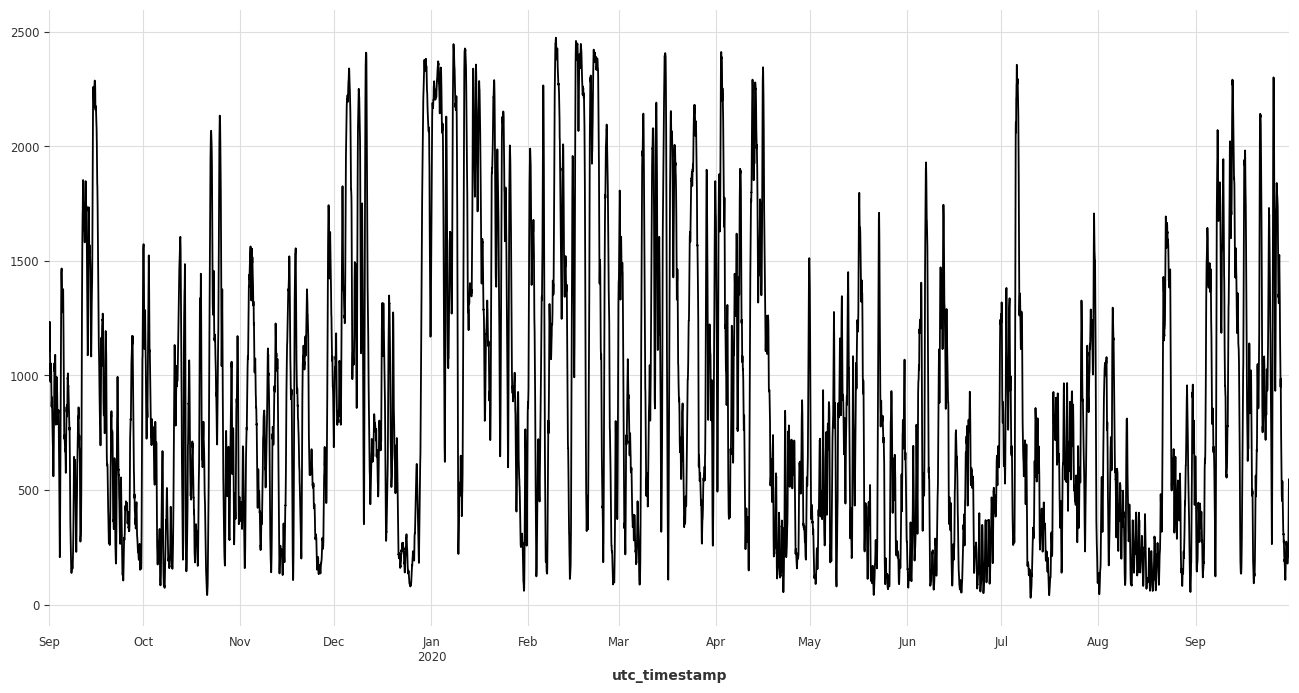

In [8]:
df['load_generation'].plot(figsize=(16,8))

<Axes: xlabel='utc_timestamp'>

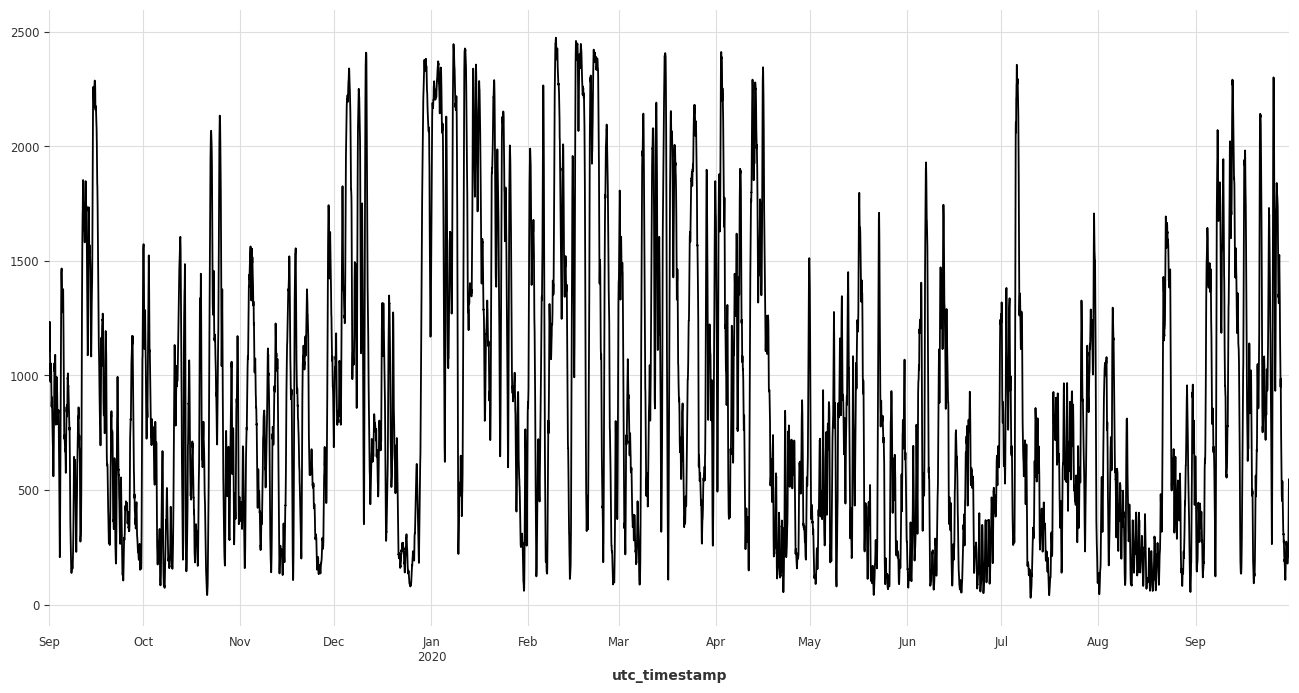

In [9]:
df['load_generation'].plot(figsize=(16,8))

<Axes: xlabel='utc_timestamp'>

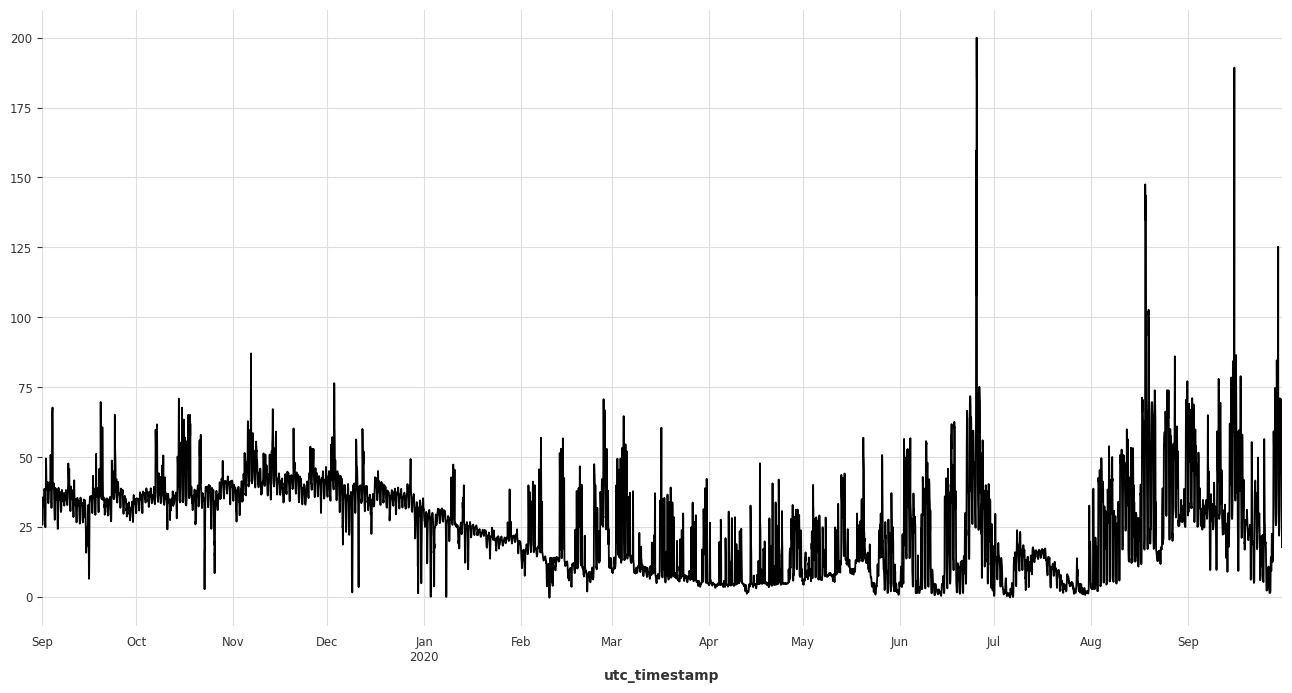

In [10]:
df['price'].plot(figsize=(16,8))

In [11]:
print("Missing value count")
print(df.isnull().sum())

Missing value count
load_actual        1
price              3
load_generation    1
dtype: int64


In [12]:
print("Missing value per columns")
print((df.isnull().mean()*100).round(3))

Missing value per columns
load_actual        0.011
price              0.032
load_generation    0.011
dtype: float64


In [13]:
for col in df.columns:
    na_blocks = df[col].isna().astype(int).groupby(df[col].notna().astype(int).cumsum()).sum()
    print(f"\nMissing blocks in {col}")
    print(na_blocks[na_blocks > 0])

# Interpretation:
# -. The tendency of missing values is a few very small gaps (likely hours)
# -. For the whole dataset, one moderate gap: 49 consecutive missing points (~ 2days) and one big gap: 97 consecutive missing points (in the beginning, trim)


Missing blocks in load_actual
load_actual
9503    1
Name: load_actual, dtype: int64

Missing blocks in price
price
5042    2
9501    1
Name: price, dtype: int64

Missing blocks in load_generation
load_generation
9503    1
Name: load_generation, dtype: int64


## EDA + Feature Engineering

In [14]:
df_imp = df.copy()

def impute_ts(df):
    # Imputation of Missing Value
    max_gap_hours = 6
    period=24*7

    for column in df.columns:
        if df[column].isnull().sum() > 0:
            # Process each gap
            # print(f"Original dataset: {df[column].isnull().sum()}")

            i = 0
            missing_mask = df[column].isnull()

            while i < len(missing_mask):
                if missing_mask.iloc[i]:
                    gap_start = i # start of the gap
                    gap_end = i # end of the gap
                    while gap_end < len(missing_mask) - 1 and missing_mask.iloc[gap_end + 1]:
                        gap_end += 1

                    gap_length_hours = gap_end - gap_start + 1

                    # STEP 1: Short gaps - Linear interpolation
                    if gap_length_hours <= max_gap_hours:
                        df[column].iloc[gap_start:gap_end+1] = df[column].iloc[gap_start:gap_end+1].interpolate()
                        # print(f"After interpolation {i}: {df[column].iloc[gap_start:gap_end+1].isnull().sum()} NaNs")

                    # STEP 2: Medium gaps - Weekly pattern matching
                    else:
                        for j in range(gap_start, gap_end + 1):
                            current_time = df[column].index[j]

                            # Look for same time in previous three weeks
                            for weeks_back in [1, 2, 3]:
                                past_time = current_time - pd.Timedelta(weeks=weeks_back)
                                if past_time in df[column].index and pd.notna(df[column].loc[past_time]):
                                    df[column].iloc[j] = df[column].loc[past_time]
                                    break

                            # If it didn't work, use daily pattern
                            if pd.isna(df[column].iloc[j]):
                                for days_back in [1, 2, 3, 7]:
                                    past_time = current_time - pd.Timedelta(days=days_back)
                                    if past_time in df[column].index and pd.notna(df[column].loc[past_time]):
                                        df[column].iloc[j] = df[column].loc[past_time]
                                        break

                        # Fill any remaining with interpolation
                        df[column].iloc[gap_start:gap_end+1] = df[column].iloc[gap_start:gap_end+1].interpolate()
                        # print(f"Final interpolation : {df[column].iloc[gap_start:gap_end+1].isnull().sum()}")

                    i = gap_end + 1
                else:
                    i += 1

        # For the remaining NaNs
        try:
            decomposition = seasonal_decompose(df[column].dropna(), model='additive', period=period)
            trend = decomposition.trend.reindex(df[column].index)
            seasonal = decomposition.seasonal.reindex(series.index)

            missing_mask = df[column].isnull()
            for idx in df[column][missing_mask].index:
                if pd.notna(trend.loc[idx]) and pd.notna(seasonal.loc[idx]):
                    df[column].loc[idx] = trend.loc[idx] + seasonal.loc[idx]

            df[column] = df[column].interpolate()

        except Exception as e:
            df[column] = df[column].interpolate()

    return df

In [15]:
df_imp = impute_ts(df_imp)

In [16]:
# This code is not necessary for the shorten dataset, however this will be useful for the whole dataset.

# # [BOUNDARY/ISOLATED CASES]: Remove problematic start period because the missing values are concentrated in the beginning of the data
# first_valid_date = max(df_imp[col].first_valid_index() for col in df_imp.columns)
# df_imp = df_imp.loc[first_valid_date:]

In [17]:
print(df_imp.isnull().sum())

load_actual        0
price              0
load_generation    0
dtype: int64


### Parameter Setting

For the following analysis (check stationary, matrix profile, motif discovery and so on whenever possible), you need to set a single variable that will be used multiple times.

Daily cycles: win = 24 --> Captures 1 full day
Multi-day cycles (weekend vs weekday): win = 24 * 7 = 168 --> Captures weekly structure
Seasonal templates (summer/winter): win = 24 * 30 ≈ 720 --> Captures monthly patterns
Load ramp patterns (morning/evening increase/decrease): win = 6–12 --> Shorter windows focus on ramp-up / ramp-down
Holiday / maintenance periods: win 24–168 -->Depends if anomaly is daily or spans a week

In [18]:
lag = 30 # for check stationary, define the lag
win = 24 # period of recurring pattern (could be day, month, season)
exc = 0.2 # for matrix profile calc, avoid trivial matches (comparing a time period to itself or immediate neighbors)

### Check stationary

Investigate stationarity by:
- using a rolling mean and standard deviation: if both stay "approximately" constant over time the time series is likely stationary
- using a stationarity test such as Augmented Dickey-Fuller test
- by investing the auto-correlation for different time *lags*.

In [19]:
def test_stationary(x, window=win, lags=lag):
    """Check stationarity using rolling statistics, ACF, and ADF test
    - rolling statistics: take a window and compute the mean and stdev within the window, then move on the window one time step
    - autocorrelation: how much the correlation between a time series and its lagged version of it
    lags: how many lagged version do we need to compute? showing by the number of bar represent in the chart
    - adf test: if ADF < 1%, 5%, 10% AND p-value < 1% --> reject H0 (non-stationary) --> this means the TS is stationary

    """

    roll_mean = x.rolling(window=window).mean()
    roll_std = x.rolling(window=window).std()

    fig, ax = plt.subplots(2, 1, figsize=(16, 12))

    # Rolling mean and std
    ax[0].plot(x, label="Original")
    ax[0].plot(roll_mean, label="Mean", linestyle='dashed')
    ax[0].plot(roll_std, label="Std Dev", linestyle='dotted')
    ax[0].legend()
    ax[0].set_title(f"Stationarity {x.name}: rolling mean and std dev, window={window}")

    # ACF plot
    plot_acf(x, lags=lags, ax=ax[1])
    ax[1].set_title(f"Stationarity ACF Plot {x.name}: Autocorrelation for lags={lags}")

    result = adfuller(x)
    print(f"ADF Test Results:{x}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")

    return fig, ax

ADF Test Results:utc_timestamp
2019-09-01 00:00:00+00:00    6126.0
2019-09-01 01:00:00+00:00    6022.0
2019-09-01 02:00:00+00:00    6022.0
2019-09-01 03:00:00+00:00    6084.0
2019-09-01 04:00:00+00:00    6280.0
                              ...  
2020-09-30 19:00:00+00:00    9293.0
2020-09-30 20:00:00+00:00    8591.0
2020-09-30 21:00:00+00:00    8030.0
2020-09-30 22:00:00+00:00    7648.0
2020-09-30 23:00:00+00:00    7648.0
Name: load_actual, Length: 9504, dtype: float64
ADF Statistic: -4.0753
p-value: 0.0011
Critical Values:
   1%: -3.4310
   5%: -2.8618
   10%: -2.5669


(<Figure size 1600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Stationarity load_actual: rolling mean and std dev, window=24'}>,
        <Axes: title={'center': 'Stationarity ACF Plot load_actual: Autocorrelation for lags=30'}>],
       dtype=object))

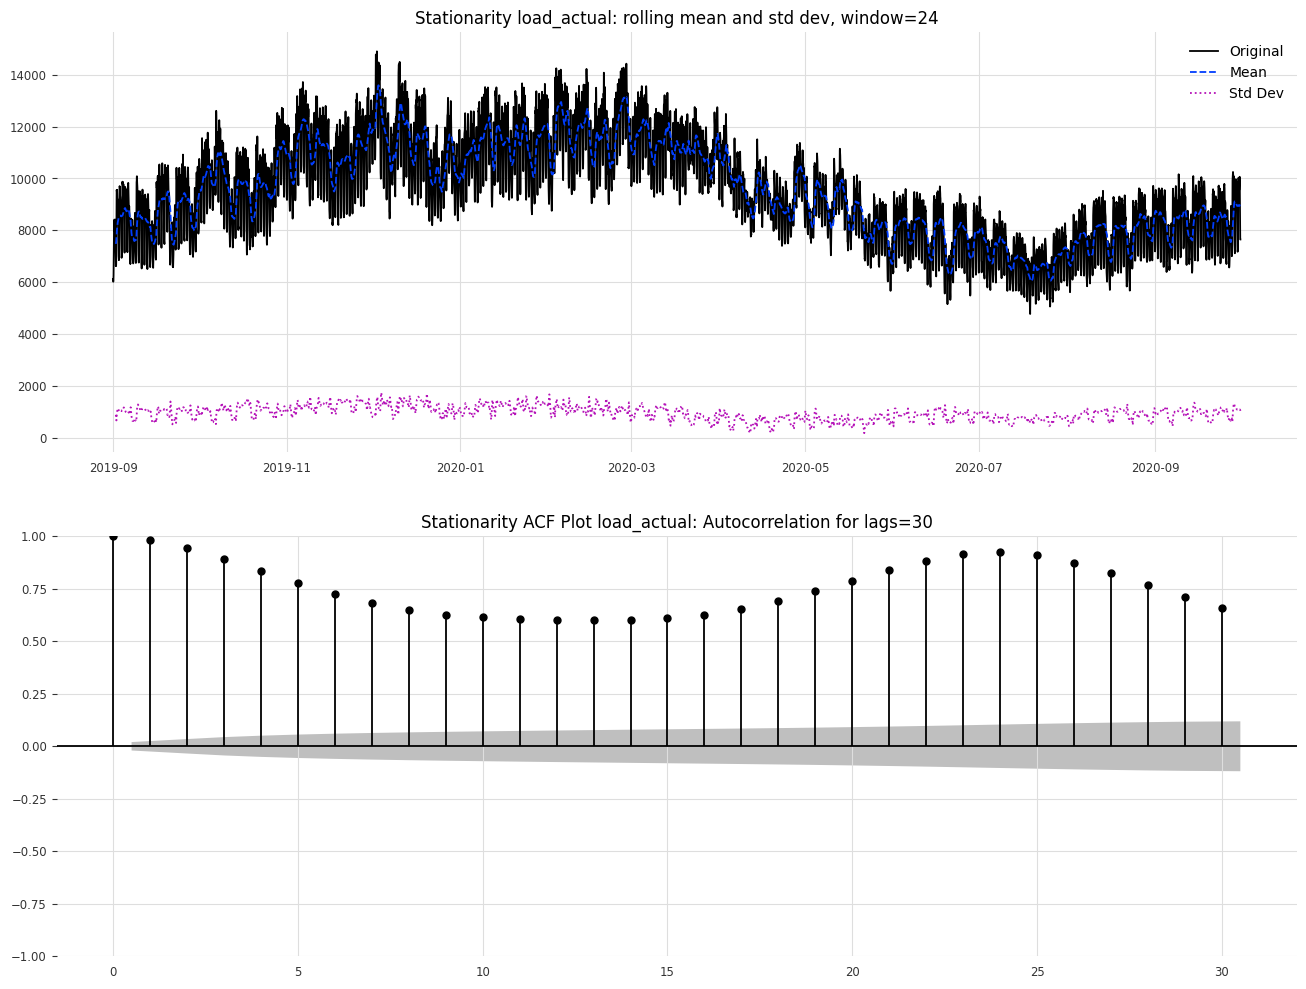

In [20]:
test_stationary(df_imp['load_actual'])

# Interpretation: the timeseries is stationary, differencing is not needed.

ADF Test Results:utc_timestamp
2019-09-01 00:00:00+00:00    26.47
2019-09-01 01:00:00+00:00    26.55
2019-09-01 02:00:00+00:00    25.91
2019-09-01 03:00:00+00:00    26.61
2019-09-01 04:00:00+00:00    27.16
                             ...  
2020-09-30 19:00:00+00:00    31.48
2020-09-30 20:00:00+00:00    28.94
2020-09-30 21:00:00+00:00    24.08
2020-09-30 22:00:00+00:00    17.85
2020-09-30 23:00:00+00:00    17.85
Name: price, Length: 9504, dtype: float64
ADF Statistic: -6.6138
p-value: 0.0000
Critical Values:
   1%: -3.4310
   5%: -2.8618
   10%: -2.5669


(<Figure size 1600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Stationarity price: rolling mean and std dev, window=24'}>,
        <Axes: title={'center': 'Stationarity ACF Plot price: Autocorrelation for lags=30'}>],
       dtype=object))

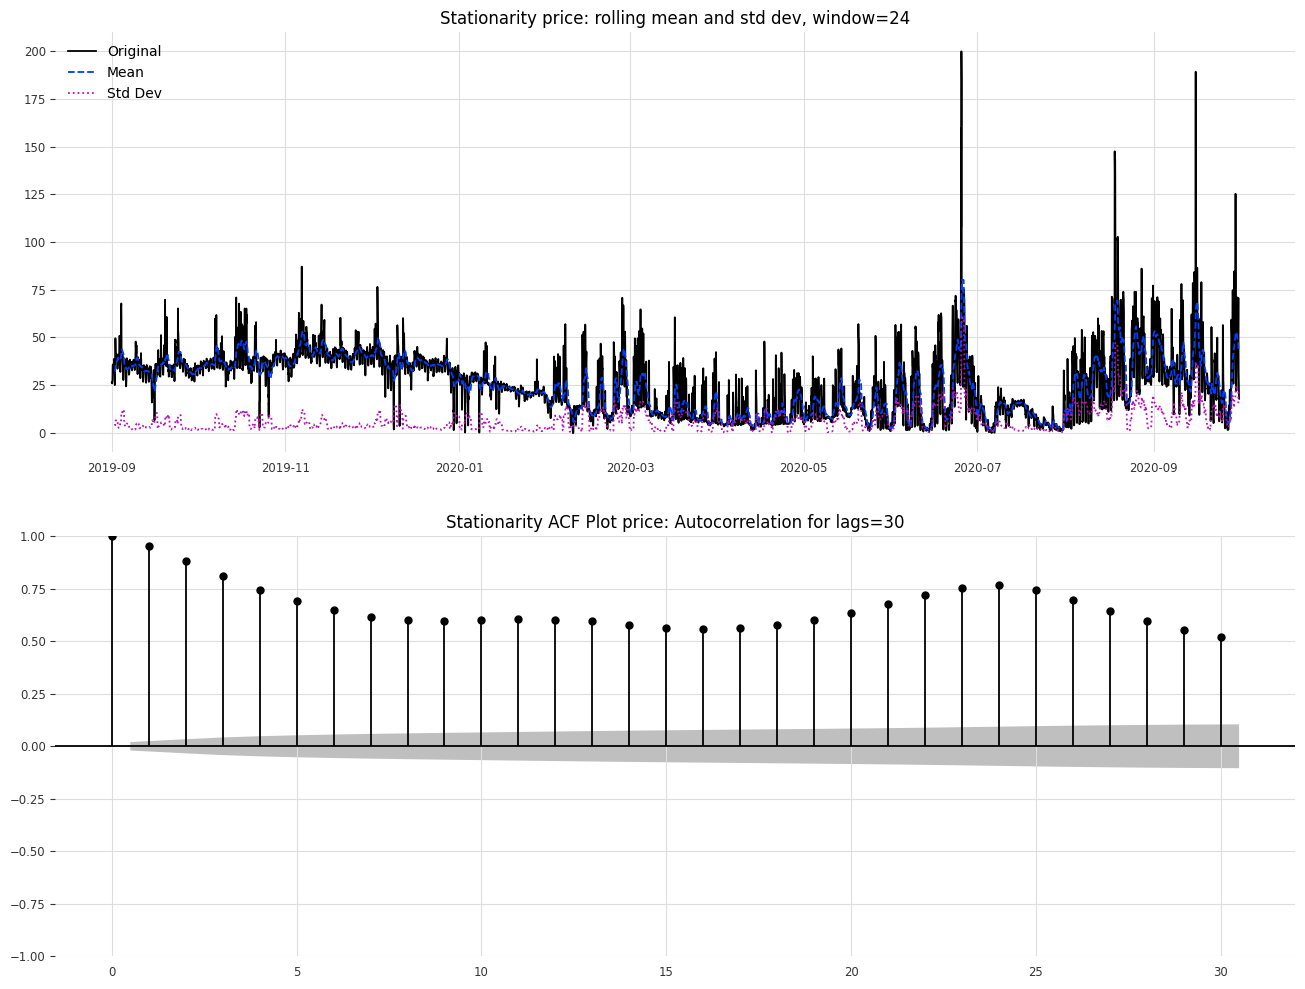

In [21]:
test_stationary(df_imp['price'])

# Interpretation: the timeseries is stationary, differencing is not needed.

ADF Test Results:utc_timestamp
2019-09-01 00:00:00+00:00    1110.0
2019-09-01 01:00:00+00:00    1123.0
2019-09-01 02:00:00+00:00    1186.0
2019-09-01 03:00:00+00:00    1234.0
2019-09-01 04:00:00+00:00    1164.0
                              ...  
2020-09-30 19:00:00+00:00     503.0
2020-09-30 20:00:00+00:00     533.0
2020-09-30 21:00:00+00:00     548.0
2020-09-30 22:00:00+00:00     507.0
2020-09-30 23:00:00+00:00     507.0
Name: load_generation, Length: 9504, dtype: float64
ADF Statistic: -8.3801
p-value: 0.0000
Critical Values:
   1%: -3.4310
   5%: -2.8618
   10%: -2.5669


(<Figure size 1600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Stationarity load_generation: rolling mean and std dev, window=24'}>,
        <Axes: title={'center': 'Stationarity ACF Plot load_generation: Autocorrelation for lags=30'}>],
       dtype=object))

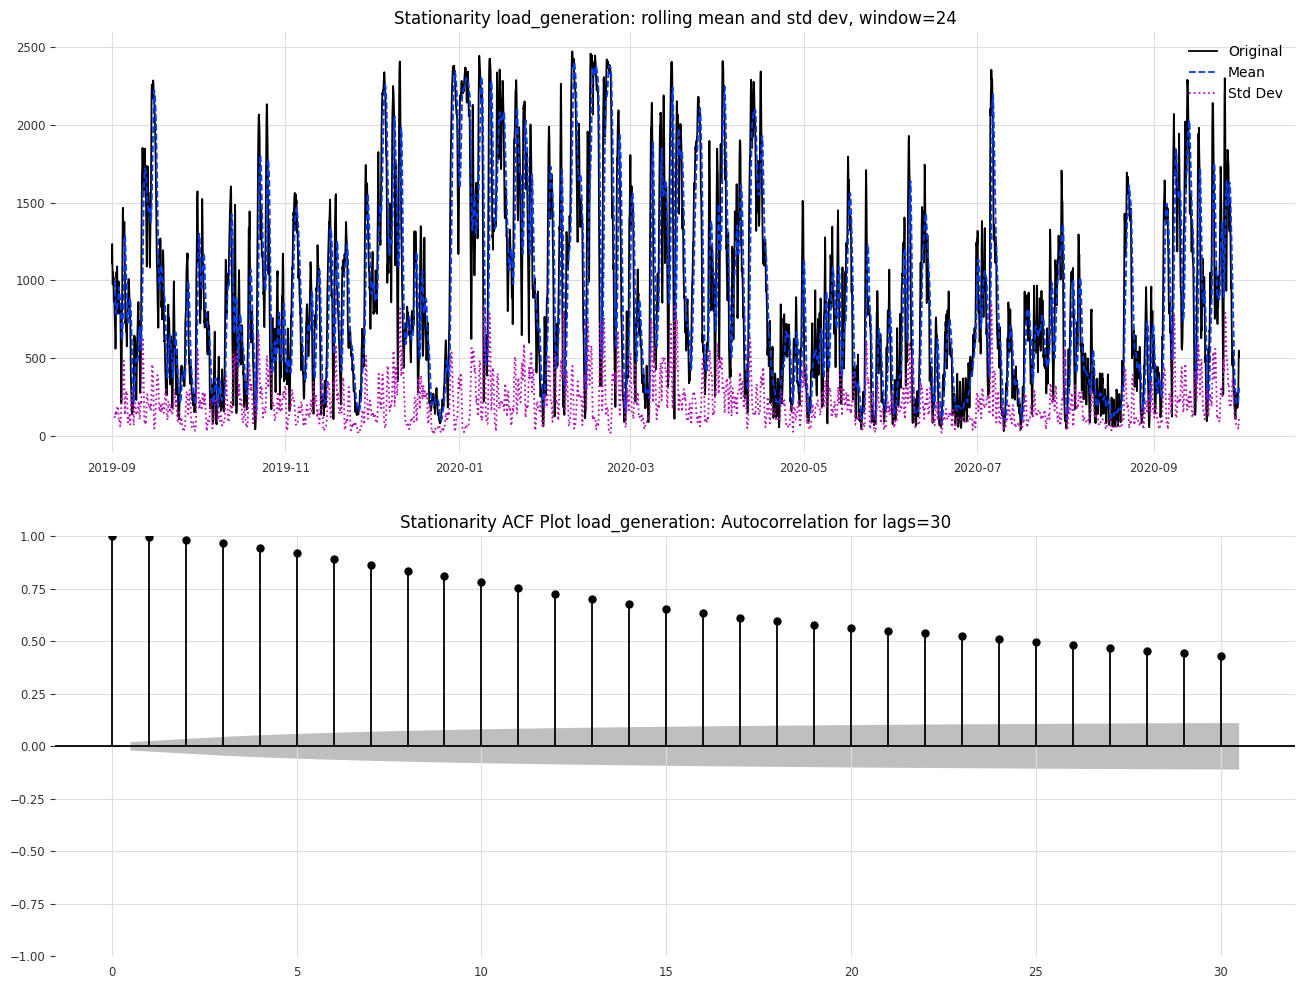

In [22]:
test_stationary(df_imp['load_generation'])

# Interpretation: the timeseries is stationary, differencing is not needed.

### Decomposition

In [23]:
def decompose_series(x, model='additive', period=win):
    """Decompose the series into trend, seasonality, and residuals."""

    decomposition = seasonal_decompose(x, model=model, period=period)

    fig, ax = plt.subplots(nrows=4, figsize=(12, 12))

    ax[0].plot(x.index, x)
    ax[0].set_ylabel("Original")
    ax[1].plot(decomposition.trend)
    ax[1].set_ylabel("Trend")
    ax[2].plot(decomposition.seasonal)
    ax[2].set_ylabel("Seasonality")
    ax[3].plot(decomposition.resid)
    ax[3].set_ylabel("Residuals")
    fig.tight_layout()
    return fig, ax

(<Figure size 1200x1200 with 4 Axes>,
 array([<Axes: ylabel='Original'>, <Axes: ylabel='Trend'>,
        <Axes: ylabel='Seasonality'>, <Axes: ylabel='Residuals'>],
       dtype=object))

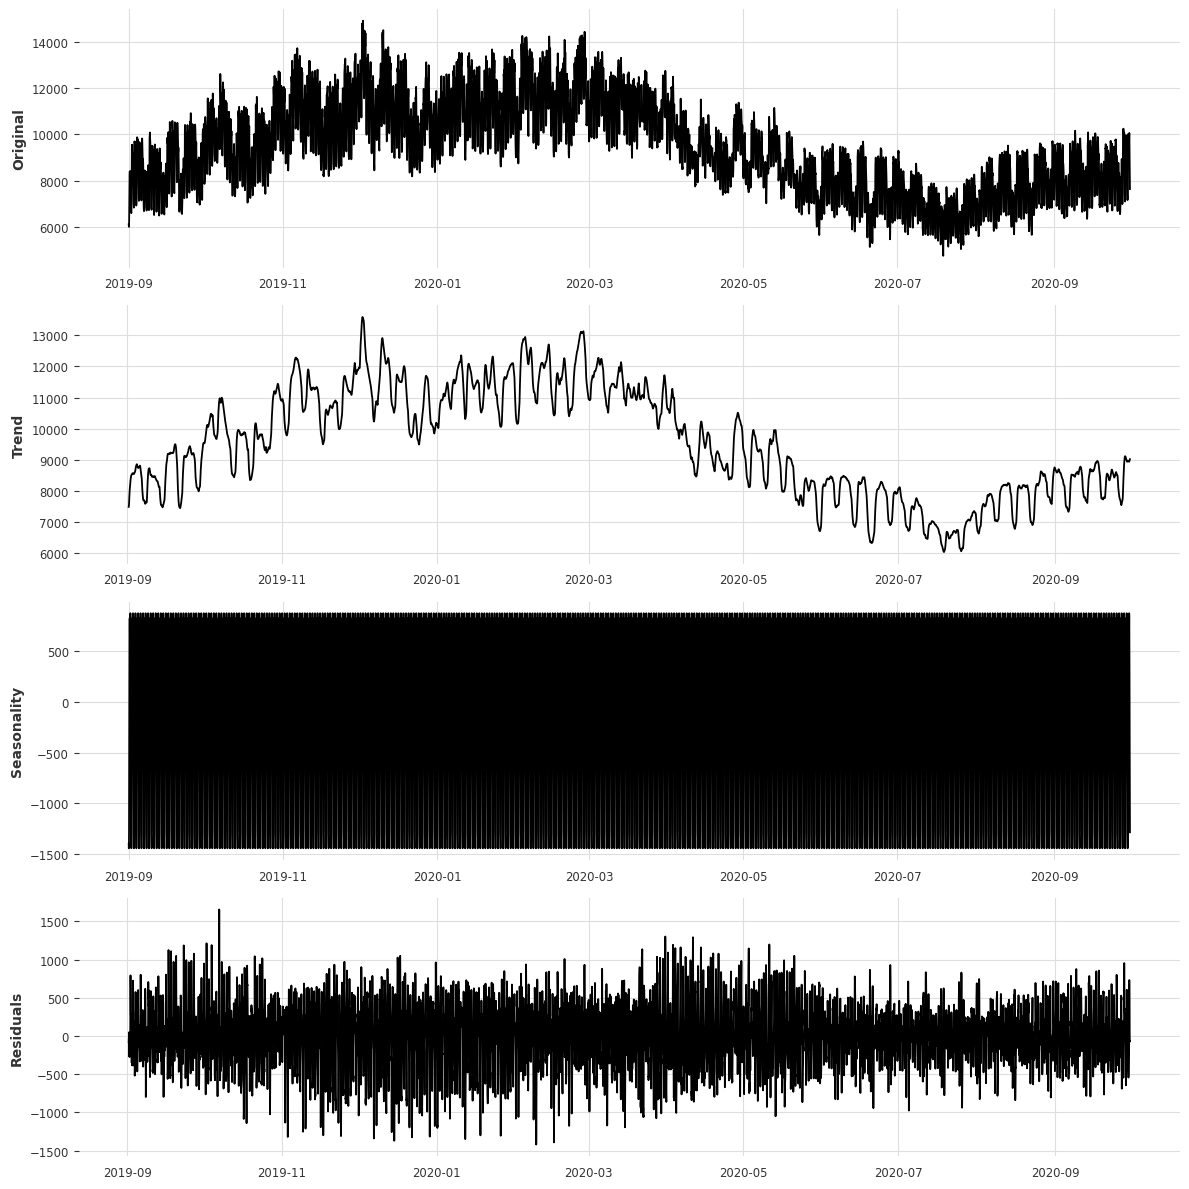

In [24]:
decompose_series(df_imp['load_actual'])

(<Figure size 1200x1200 with 4 Axes>,
 array([<Axes: ylabel='Original'>, <Axes: ylabel='Trend'>,
        <Axes: ylabel='Seasonality'>, <Axes: ylabel='Residuals'>],
       dtype=object))

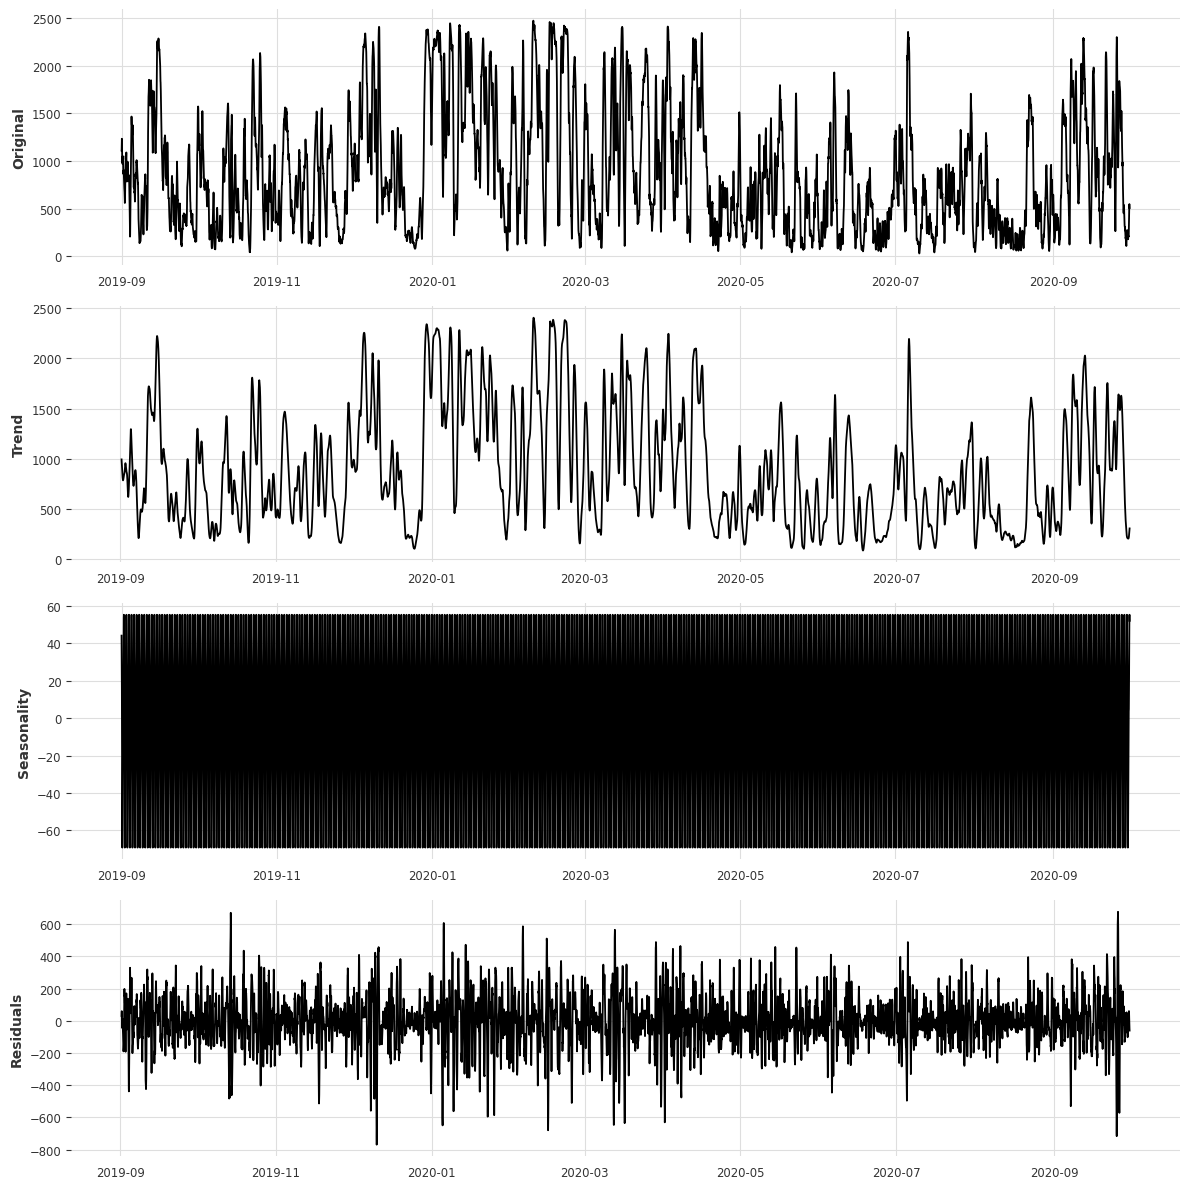

In [25]:
decompose_series(df_imp['load_generation'])

(<Figure size 1200x1200 with 4 Axes>,
 array([<Axes: ylabel='Original'>, <Axes: ylabel='Trend'>,
        <Axes: ylabel='Seasonality'>, <Axes: ylabel='Residuals'>],
       dtype=object))

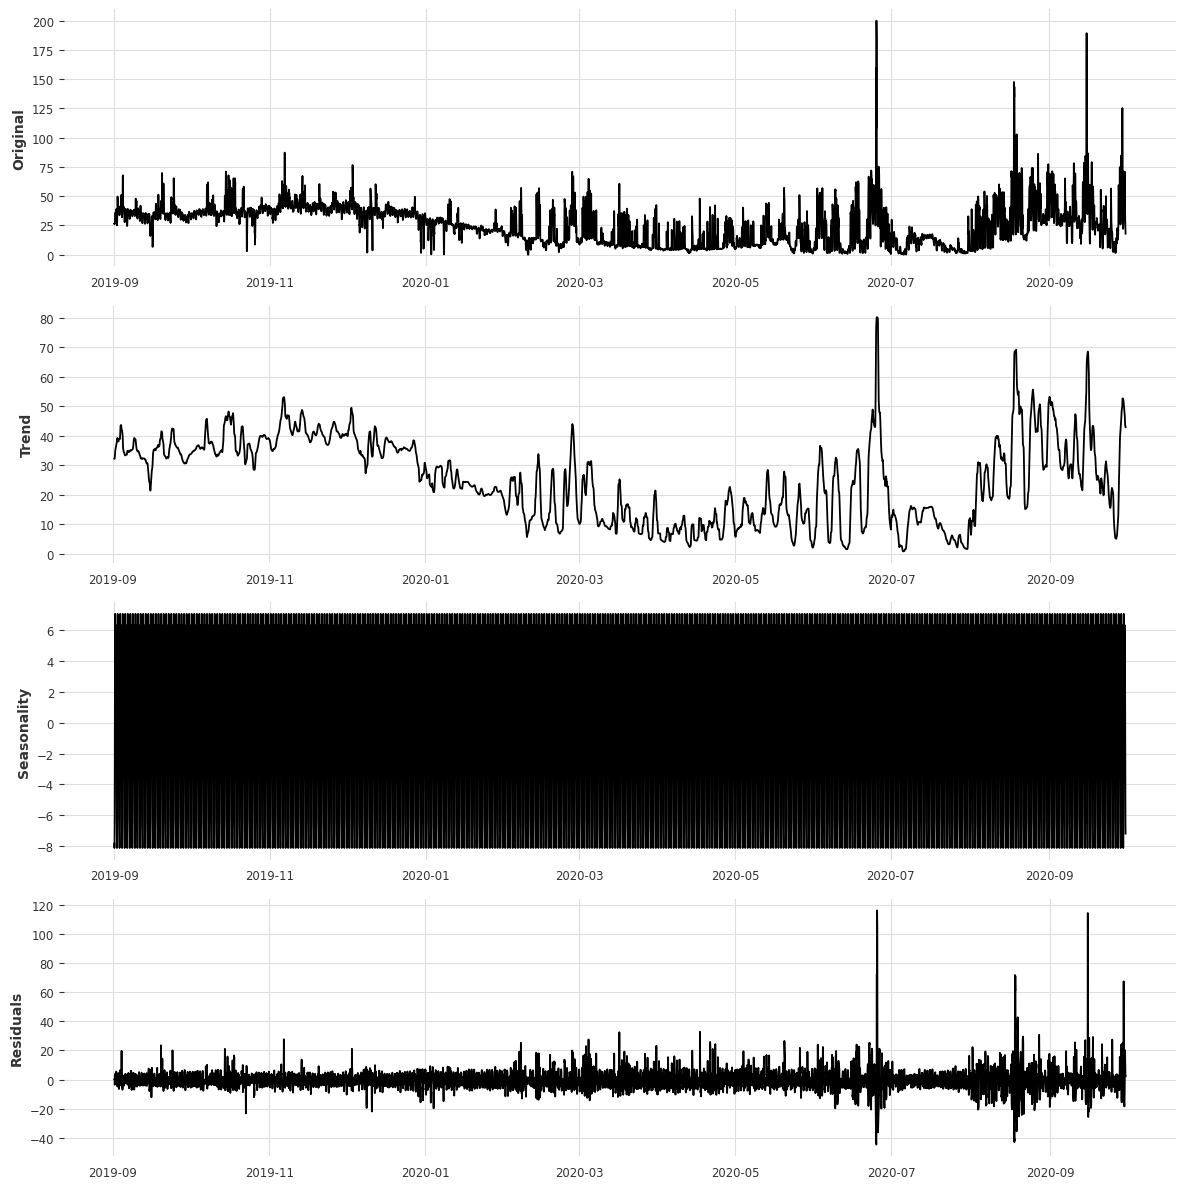

In [26]:
decompose_series(df_imp['price'])

### Matrix Profile using MASS for faster implementation

It helps us to understand:
- recurring daily patterns: which days had similar load curve
- seasonal similarities: find similar weeks/months across different year
- anomaly detection: high matrix profile value = unusual periods with no similar pattern
- pattern stability: low values = recurring, predictable patterns

Two parts represent: <br>
-. minimum distance of every possible query of window size <br>
-. index of the time series with the closest counterparts. <br>


In [27]:
def compute_matrix_profile(x, window=win, exclude=exc, return_index=True, top_k=5):
    start = time.time()
    mp, mp_idx = matrix_profile(x, window=window, exclude=exclude, return_index=True)

    fig, ax= plt.subplots(2, figsize=(16,12))
    ax[0].plot(mp)
    ax[0].set_title("Matrix Profile")
    ax[1].plot(x.index, x.values, label="Original", color='gray', alpha=0.7)

    # Find most recurring patterns (lowest MP values)
    min_idx = np.argsort(mp)[:top_k]  # Top 5 most similar patterns

    colors = ["red", "green", "orange", "purple", "blue"]
    print(f"Most recurring patterns (lowest distances):")

    for j, idx in enumerate(min_idx):
        if not np.isnan(mp[idx]):
            partner_idx = mp_idx[idx]
            pattern_time = x.index[idx]
            partner_time = x.index[partner_idx]

            pattern_time_num = mdates.date2num(pattern_time)
            partner_time_num = mdates.date2num(partner_time)

            time_width = mdates.date2num(pattern_time + pd.Timedelta(hours=window)) - pattern_time_num

            # Highlight subsequences on plot
            ax[1].add_patch(Rectangle((pattern_time_num, x.iloc[idx]),   # rectangle at motif start
                                      time_width, (x.max() - x.min()) * 0.1, # matplotlib needs the actual time span on the x-axis.
                                      linewidth=3, edgecolor=colors[j % len(colors)],
                                      facecolor=colors[j % len(colors)], alpha=0.3,
                                      label=f'Motif {j+1}'))
            ax[1].add_patch(Rectangle((partner_time_num, x.iloc[partner_idx]),
                                      time_width, (x.max() - x.min()) * 0.1,
                                      linewidth=3, edgecolor=colors[j % len(colors)],
                                      facecolor=colors[j % len(colors)], alpha=0.3))

            # Print info
            pattern_date = x.index[idx]
            partner_date = x.index[partner_idx] if partner_idx < len(x) else "N/A"
            print(f"  {j+1}. {pattern_date} (distance: {mp[idx]:.2f}, similar to: {partner_date})")

    ax[1].set_title("Original Series with Highlighted Motifs")
    ax[1].legend()
    plt.tight_layout()
    plt.show()

    print(f"Execution time: {time.time() - start:.2f} secs")
    return mp, mp_idx

Most recurring patterns (lowest distances):
  1. 2019-11-21 22:00:00+00:00 (distance: 0.19, similar to: 2019-11-17 22:00:00+00:00)
  2. 2019-11-17 22:00:00+00:00 (distance: 0.19, similar to: 2019-11-21 22:00:00+00:00)
  3. 2019-12-21 01:00:00+00:00 (distance: 0.20, similar to: 2019-12-14 01:00:00+00:00)
  4. 2019-12-14 01:00:00+00:00 (distance: 0.20, similar to: 2019-12-21 01:00:00+00:00)
  5. 2019-12-14 04:00:00+00:00 (distance: 0.21, similar to: 2019-12-21 04:00:00+00:00)


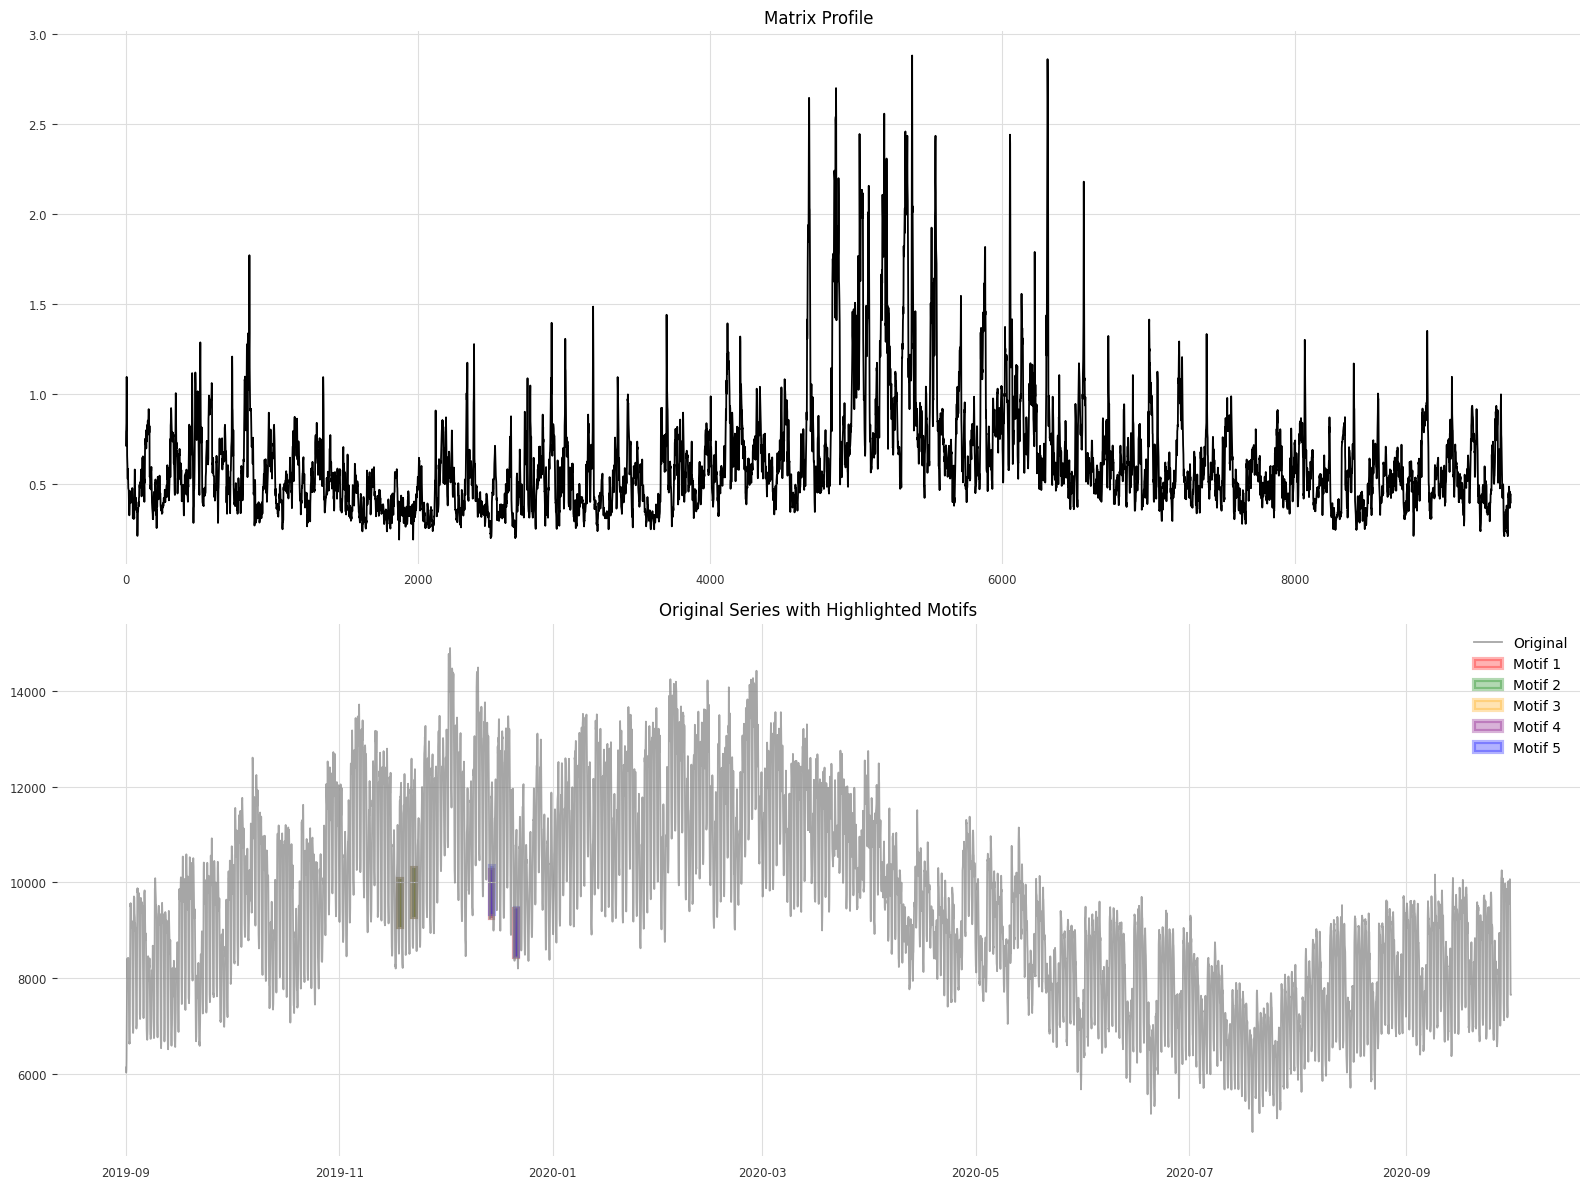

Execution time: 13.01 secs


In [28]:
mp_load, mp_idx_load = compute_matrix_profile(df_imp['load_actual'], window=win, exclude=exc)

Most recurring patterns (lowest distances):
  1. 2020-02-08 19:00:00+00:00 (distance: 0.17, similar to: 2019-11-17 17:00:00+00:00)
  2. 2019-11-17 17:00:00+00:00 (distance: 0.17, similar to: 2020-02-08 19:00:00+00:00)
  3. 2019-11-17 18:00:00+00:00 (distance: 0.17, similar to: 2020-02-08 20:00:00+00:00)
  4. 2020-02-08 20:00:00+00:00 (distance: 0.17, similar to: 2019-11-17 18:00:00+00:00)
  5. 2019-11-28 06:00:00+00:00 (distance: 0.21, similar to: 2020-05-22 01:00:00+00:00)


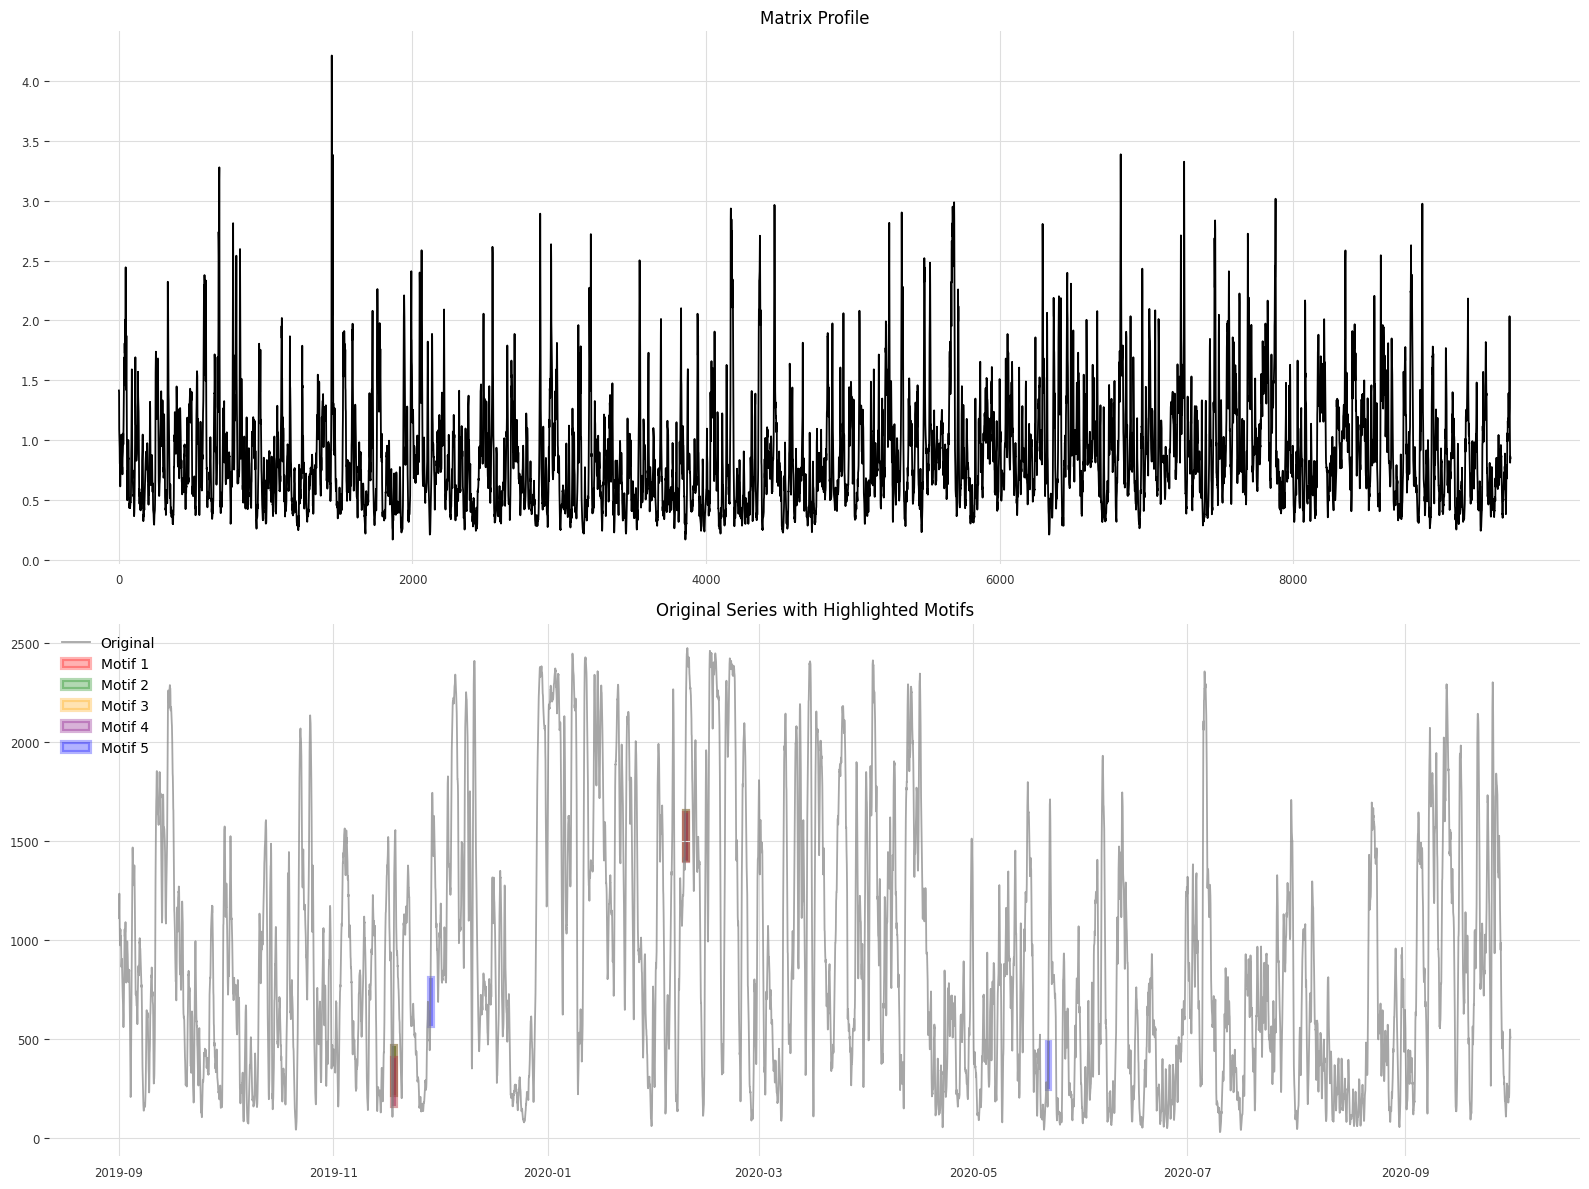

Execution time: 7.03 secs


In [29]:
mp_gen, mp_idx_gen = compute_matrix_profile(df_imp['load_generation'])

Most recurring patterns (lowest distances):
  1. 2020-03-15 08:00:00+00:00 (distance: 0.27, similar to: 2020-07-30 08:00:00+00:00)
  2. 2020-07-30 08:00:00+00:00 (distance: 0.27, similar to: 2020-03-15 08:00:00+00:00)
  3. 2020-04-08 10:00:00+00:00 (distance: 0.35, similar to: 2020-03-31 10:00:00+00:00)
  4. 2020-03-31 10:00:00+00:00 (distance: 0.35, similar to: 2020-04-08 10:00:00+00:00)
  5. 2020-07-10 04:00:00+00:00 (distance: 0.40, similar to: 2019-11-01 04:00:00+00:00)


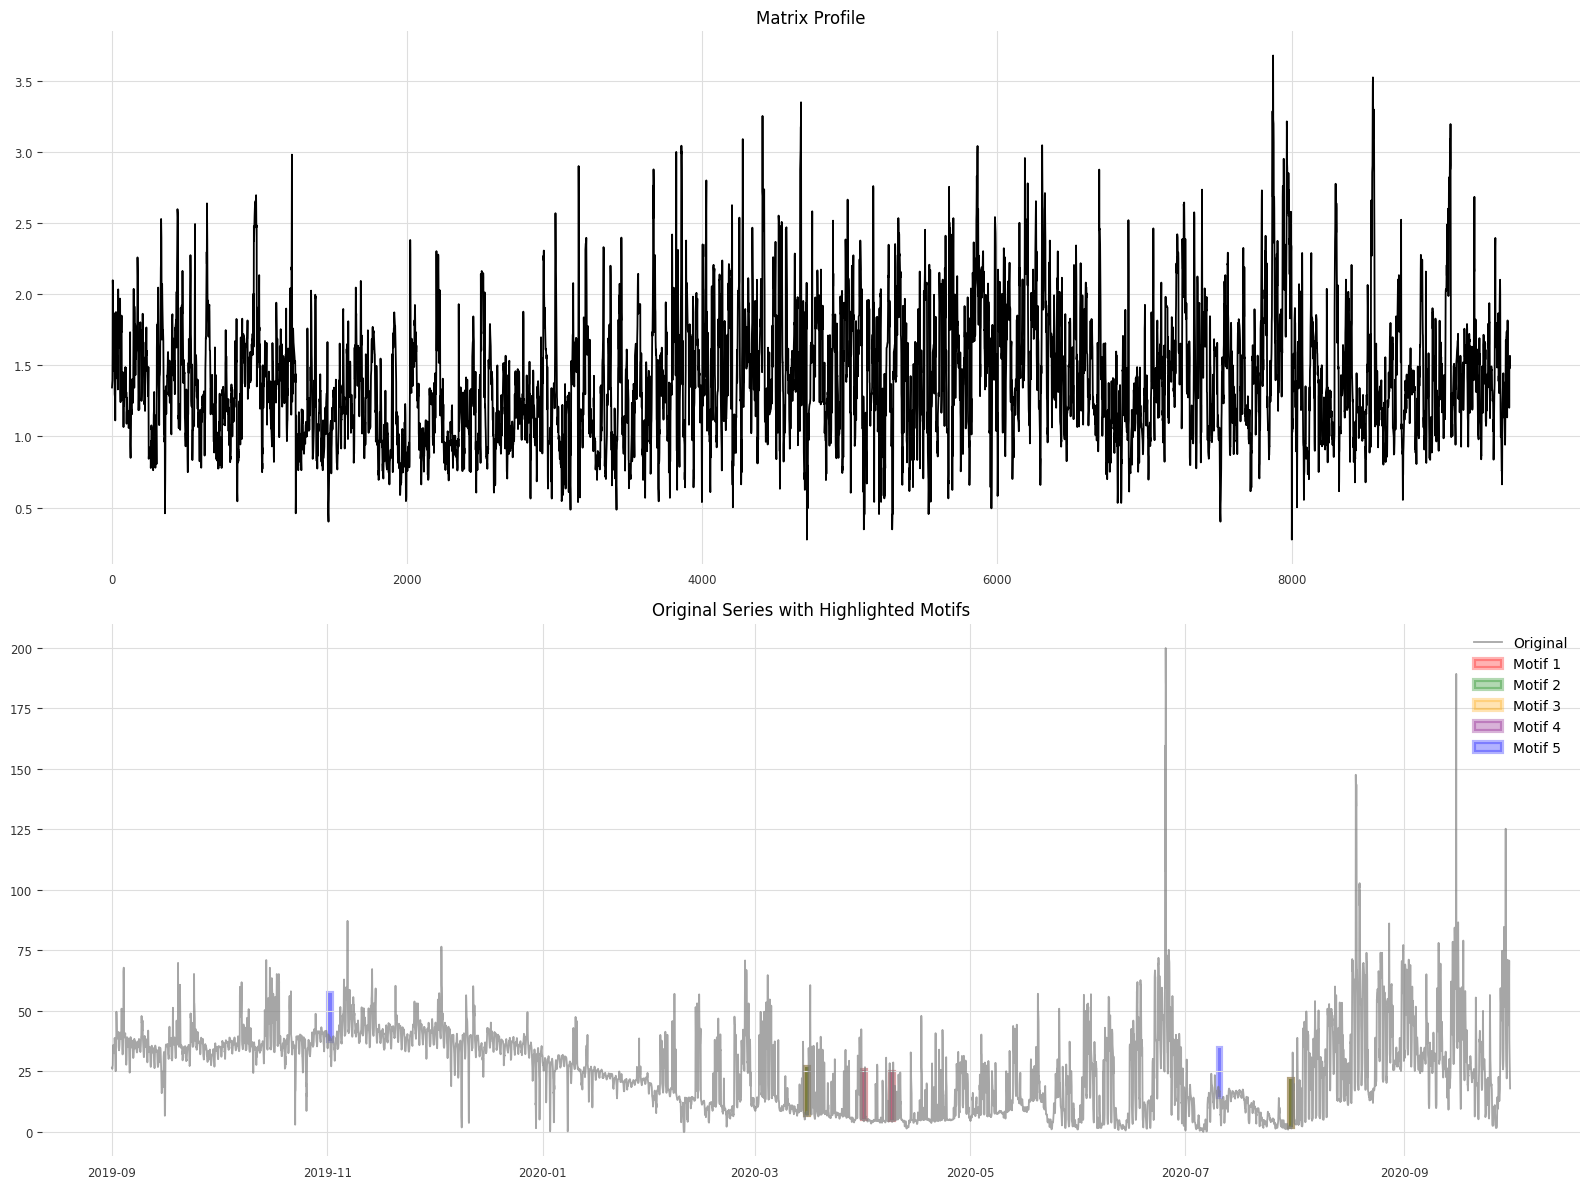

Execution time: 8.04 secs


In [30]:
mp_price, mp_idx_price = compute_matrix_profile(df_imp['price'])

### Motif discovery

It could represent:
- typical daily cycles: weekend vs. weekdays
- seasonal templates: standard summer / winter consumption curves
- event patterns: holiday consumption/maintenance period
- load ramp patterns: how consumption typically increases/decreases

Therefore, motif discovery helps energy company to capacity planning, anomaly detection (deviations from motif), or pricing strategies.

Mechanism:
1. Note that those points that minimize the MatrixProfile have a close counterpart somewhere else.
2. Start with the smallest, `mp`-value and search for all subsequences close to it.
    - Exclude those that are far away (user tunable threshold)


In [31]:
def find_motifs_for_series(series):
    return annotate.motifs(series, window=win, max_distance=1, max_motif=3, min_neighbours=2)

def parallel_motifs():
    with Pool() as pool:
        all_motifs = pool.map(find_motifs_for_series, df_imp.T.values)
    return all_motifs

# It takes a little bit longer time to process, comment if you want to fasten the process
all_motifs = parallel_motifs()

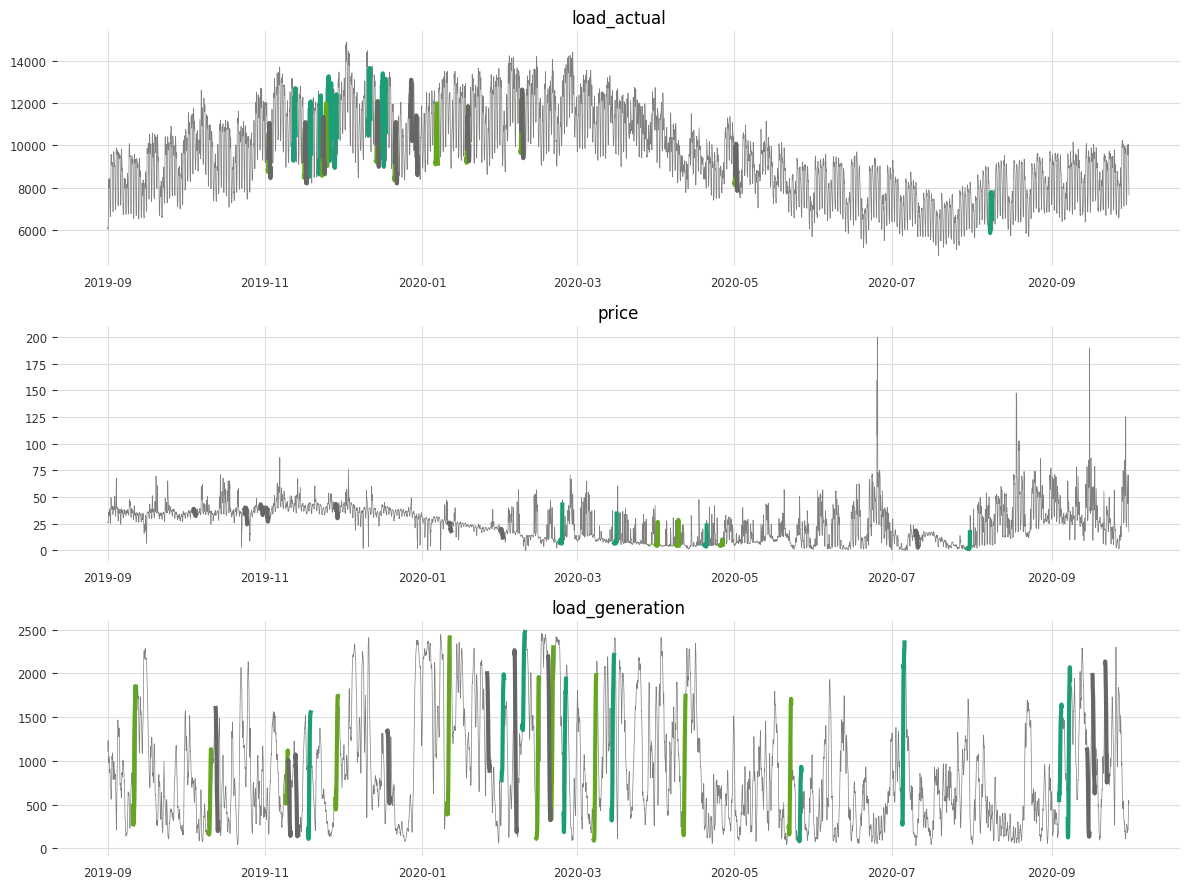

In [32]:
# It takes a little bit longer time to process, comment if you want to fasten the process
fig, ax = plt.subplots(nrows=len(df_imp.columns), figsize=(12, 3*len(df_imp.columns)))
for i, col in enumerate(df_imp.columns):
    ax[i].plot(df_imp.index, df_imp[col], color="gray", lw=0.5)
    ax[i].set_title(str(col))

def plot_motifs(X, all_motifs, *, ax, window):
    cmap = plt.get_cmap("Dark2", len(all_motifs))
    for j, motifs in enumerate(all_motifs):
        for motif in motifs:
            time_idx = df_imp.index[motif:motif+window]
            ax.plot(time_idx, X[motif:motif+window], color=cmap(j), lw=3)

for i, col in enumerate(df_imp.columns):
    plot_motifs(df_imp[col].values, all_motifs[i], ax=ax[i], window=win)

fig.tight_layout()
plt.show()


### Seasonal Analysis

Analyze how patterns vary by season, day of week, etc. This would be more useful in the longer datasets (more than one year)

In [33]:
def season_analysis(df, col, lab):
  df_analysis = df.copy()
  column = col
  df_analysis.index = pd.to_datetime(df_analysis.index)
  df_analysis['hour'] = df_analysis.index.hour
  df_analysis['day_of_week'] = df_analysis.index.dayofweek
  df_analysis['month'] = df_analysis.index.month
  df_analysis['season'] = df_analysis['month'].map({
      12: 'Winter', 1: 'Winter', 2: 'Winter',
      3: 'Spring', 4: 'Spring', 5: 'Spring',
      6: 'Summer', 7: 'Summer', 8: 'Summer',
      9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
  })

  fig, axes = plt.subplots(2, 2, figsize=(15, 10))

  # Daily patterns by season
  for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
      season_data = df_analysis[df_analysis['season'] == season]
      daily_pattern = season_data.groupby('hour')[column].mean()
      axes[0,0].plot(daily_pattern.index, daily_pattern.values,
                      label=season, linewidth=2)

  axes[0,0].set_title(f'Daily {lab} Pattern by Season')
  axes[0,0].set_xlabel('Hour of Day')
  axes[0,0].set_ylabel('Average Load')
  axes[0,0].legend()
  axes[0,0].grid(True, alpha=0.3)

  # Weekly patterns
  days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
  weekly_pattern = df_analysis.groupby('day_of_week')[column].mean()
  axes[0,1].bar(range(7), weekly_pattern.values)
  axes[0,1].set_title(f'Average {lab} by Day of Week')
  axes[0,1].set_xticks(range(7))
  axes[0,1].set_xticklabels(days)
  axes[0,1].set_ylabel('Average Load')

  # Monthly patterns
  monthly_pattern = df_analysis.groupby('month')[column].mean()
  axes[1,0].plot(monthly_pattern.index, monthly_pattern.values, 'o-', linewidth=2)
  axes[1,0].set_title(f'Average {lab} by Month')
  axes[1,0].set_xlabel('Month')
  axes[1,0].set_ylabel('Average Load')
  axes[1,0].grid(True, alpha=0.3)

  # Heatmap of hour vs day of week
  pivot_data = df_analysis.pivot_table(values=column, index='hour',
                                      columns='day_of_week', aggfunc='mean')
  sns.heatmap(pivot_data, ax=axes[1,1], cmap='YlOrRd',
              xticklabels=days, cbar_kws={'label': f'Average Load {lab}'})
  axes[1,1].set_title(f'{lab} Heatmap: Hour vs Day of Week')

  plt.tight_layout()
  plt.show()

  # Print insights
  print(f"===Key Insights {lab}===")
  peak_season = monthly_pattern.idxmax()
  low_season = monthly_pattern.idxmin()
  print(f"- Peak {lab} month: {peak_season}")
  print(f"- Lowest {lab} month: {low_season}")

  peak_day = weekly_pattern.idxmax()
  low_day = weekly_pattern.idxmin()
  print(f"- Highest {lab} day: {days[peak_day]}")
  print(f"- Lowest {lab} day: {days[low_day]}")

  daily_avg = df_analysis.groupby('hour')[column].mean()
  peak_hour = daily_avg.idxmax()
  low_hour = daily_avg.idxmin()
  print(f"- Peak {lab} hour: {peak_hour:02d}:00")
  print(f"- Lowest {lab} hour: {low_hour:02d}:00")

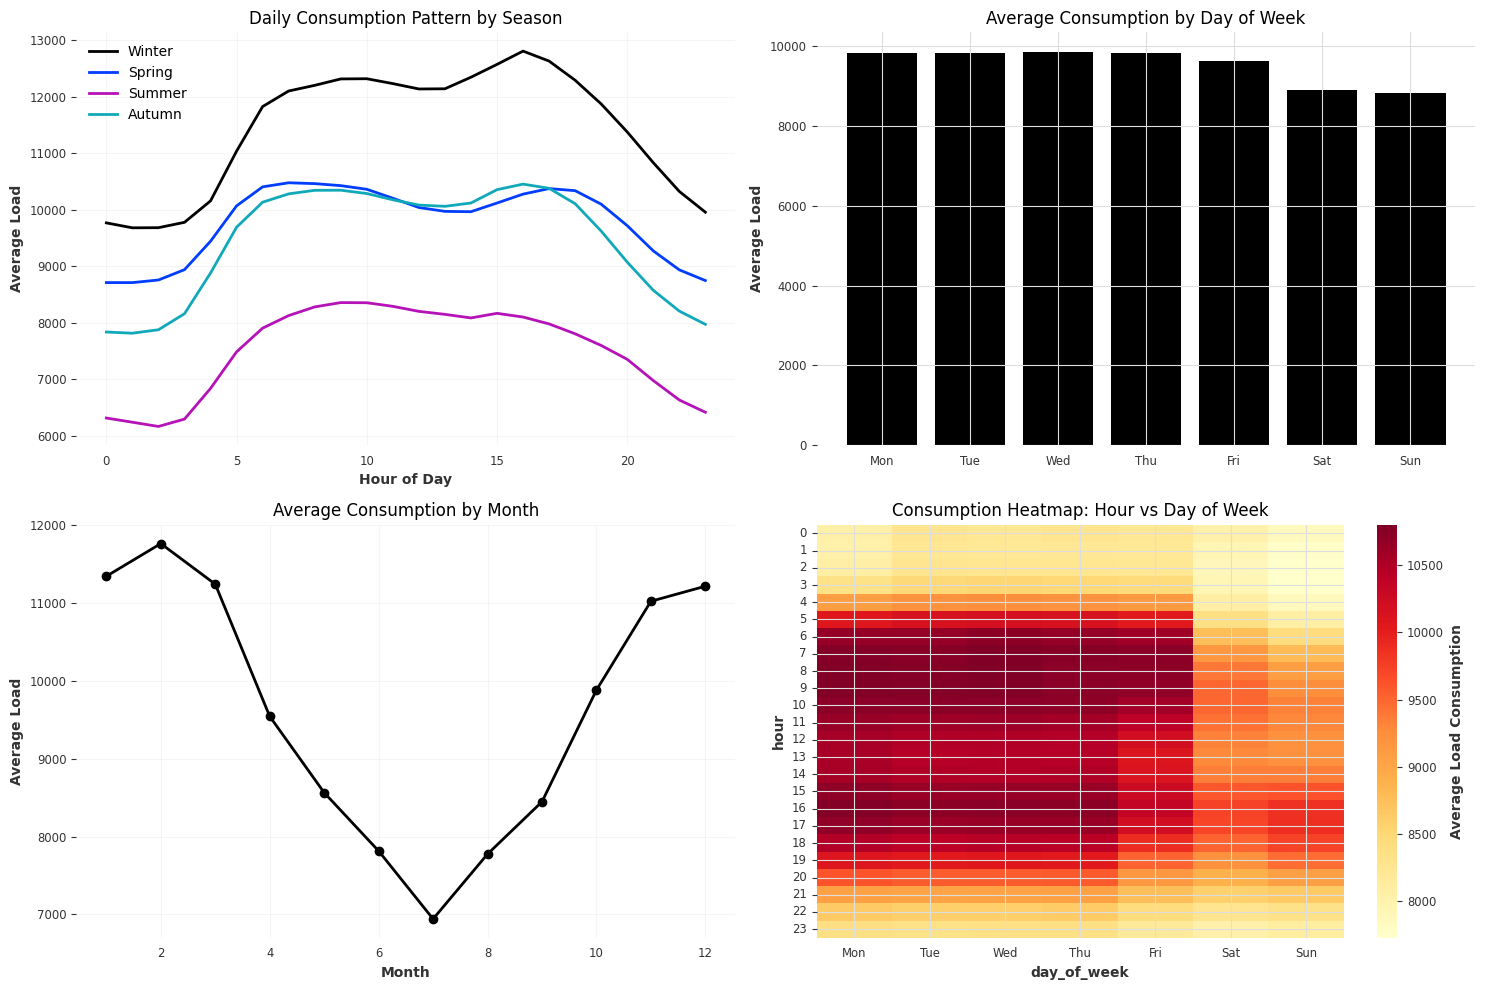

===Key Insights Consumption===
- Peak Consumption month: 2
- Lowest Consumption month: 7
- Highest Consumption day: Wed
- Lowest Consumption day: Sun
- Peak Consumption hour: 16:00
- Lowest Consumption hour: 01:00


In [34]:
season_analysis(df_imp, 'load_actual', 'Consumption')

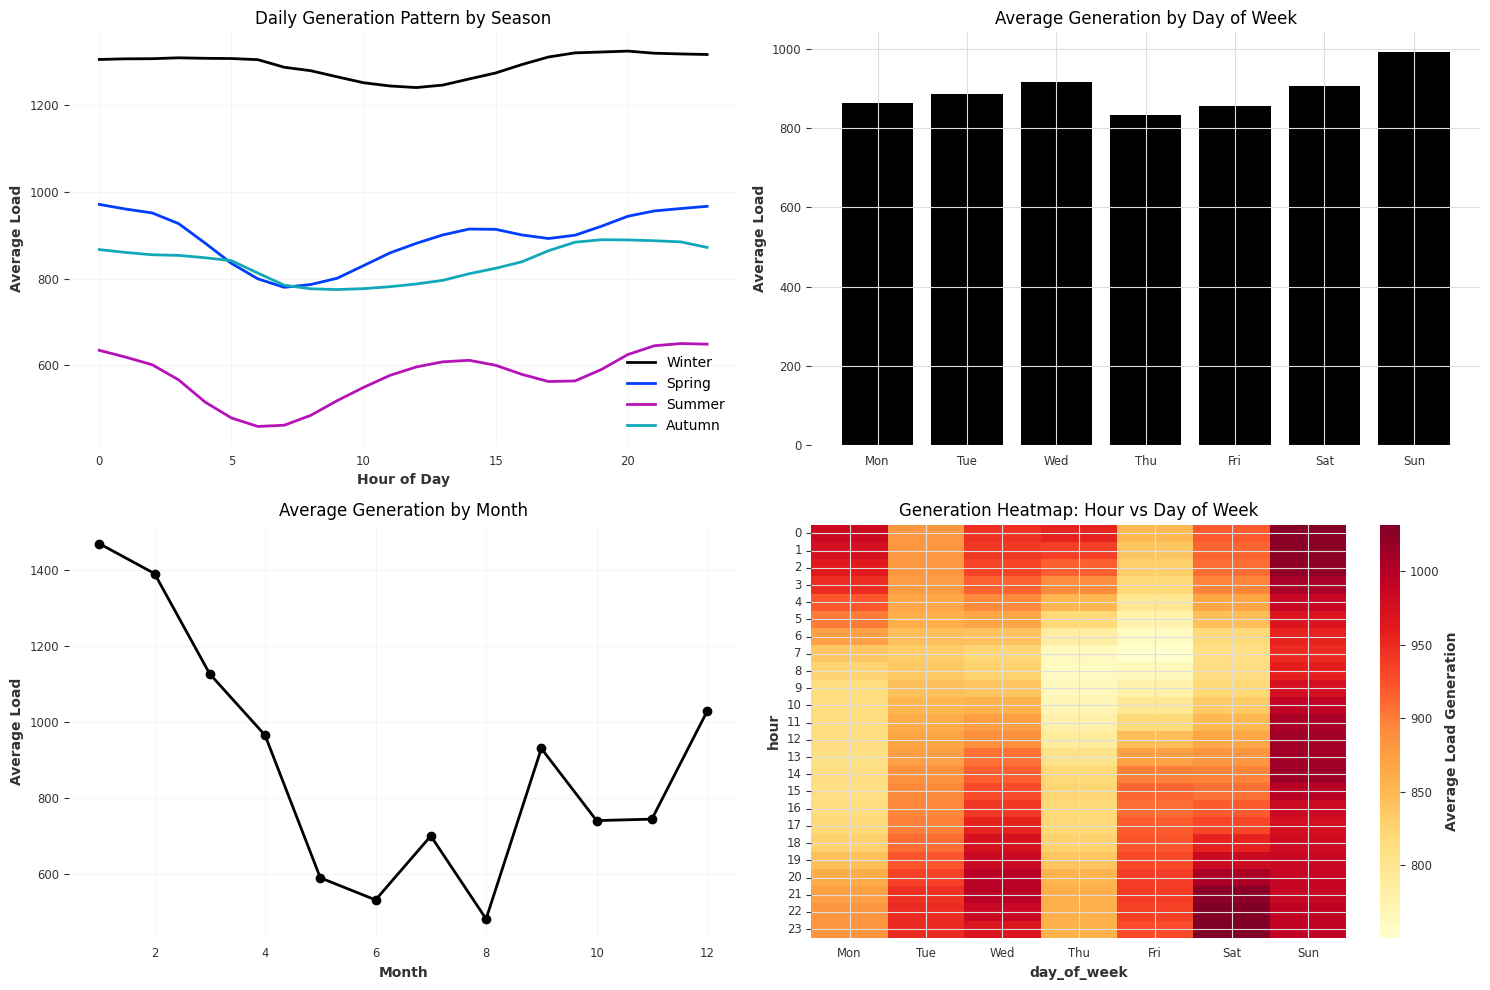

===Key Insights Generation===
- Peak Generation month: 1
- Lowest Generation month: 8
- Highest Generation day: Sun
- Lowest Generation day: Thu
- Peak Generation hour: 22:00
- Lowest Generation hour: 07:00


In [35]:
season_analysis(df_imp, 'load_generation', 'Generation')

## Forecast

Outline:
1. Train-test split
2. SARIMA
3. N-BEATS
4. LSTM Forecasting
5. Timeseries Classification with Rocket

**For simplicity, we'll use 'load_actual' as the target. However, it's possible to modify the code based on the needs.**

### 0. Evaluation

For comparison between model

In [36]:
def evaluate_forecasts(predictions, actuals, model_name="Model"):
    """
    Evaluate forecasting performance
    """
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    print(f"\n{model_name} Performance:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAPE: {mape:.2f}%")

    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

def plot_forecasts(predictions, actuals, model_name="Model", n_show=24*7):
    """
    Plot forecast results
    """
    plt.figure(figsize=(15, 6))

    # Show only first n_show points for clarity
    show_pred = predictions[:n_show]
    show_actual = actuals[:n_show]

    plt.plot(show_actual, label='Actual', linewidth=2)
    plt.plot(show_pred, label=f'{model_name} Prediction', linewidth=2, alpha=0.8)
    plt.title(f'{model_name} Forecast vs Actual')
    plt.xlabel('Hours')
    plt.ylabel('Load')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


### 1. Train-test split

The test data is unseen future to avoid data leakage.

Estimation: <br>
Training: 70% <br>
Validation: 10% <br>
Test: 20% <br>

In [37]:
class TimeSeriesTrainTest:
    """
    Proper time series data splitting and preparation
    """

    def __init__(self, df, target_col='load_actual', test_size=0.3, val_size=0.1):
        self.df = df.copy()
        self.target_col = target_col
        self.test_size = test_size
        self.val_size = val_size

    def temporal_split(self):
        """
        Split data temporally, respect the sequence
        """

        total_len = len(self.df)

        # Calculate split points
        train_end = int(total_len * (1 - self.test_size - self.val_size))
        val_end = int(total_len * (1 - self.test_size))

        # Split the data
        train_data = self.df.iloc[:train_end]
        val_data = self.df.iloc[train_end:val_end]
        test_data = self.df.iloc[val_end:]

        print(f"Training data: {train_data.index[0]} to {train_data.index[-1]} ({len(train_data)} points)")
        print(f"Validation data: {val_data.index[0]} to {val_data.index[-1]} ({len(val_data)} points)")
        print(f"Test data: {test_data.index[0]} to {test_data.index[-1]} ({len(test_data)} points)")

        # Visualize split
        plt.figure(figsize=(15, 6))
        plt.plot(train_data.index, train_data[self.target_col], label='Train', alpha=0.7)
        plt.plot(val_data.index, val_data[self.target_col], label='Validation', alpha=0.7)
        plt.plot(test_data.index, test_data[self.target_col], label='Test', alpha=0.7)
        plt.title('Time Series Data Split')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        return train_data, val_data, test_data

    def create_sequences(self, data, lookback_window=None, forecast_horizon=24):
        """
        Create sequences for deep learning models
        """
        if lookback_window is None:
            lookback_window = 24*7

        X, y = [], []

        for i in range(lookback_window, len(data) - forecast_horizon + 1):
            # Features: past 'lookback_window' hours
            X.append(data.iloc[i-lookback_window:i].values)
            # Target: next 'forecast_horizon' hours
            y.append(data[self.target_col].iloc[i:i+forecast_horizon].values)

        return np.array(X), np.array(y)

Training data: 2019-09-01 00:00:00+00:00 to 2020-04-25 13:00:00+00:00 (5702 points)
Validation data: 2020-04-25 14:00:00+00:00 to 2020-06-04 03:00:00+00:00 (950 points)
Test data: 2020-06-04 04:00:00+00:00 to 2020-09-30 23:00:00+00:00 (2852 points)


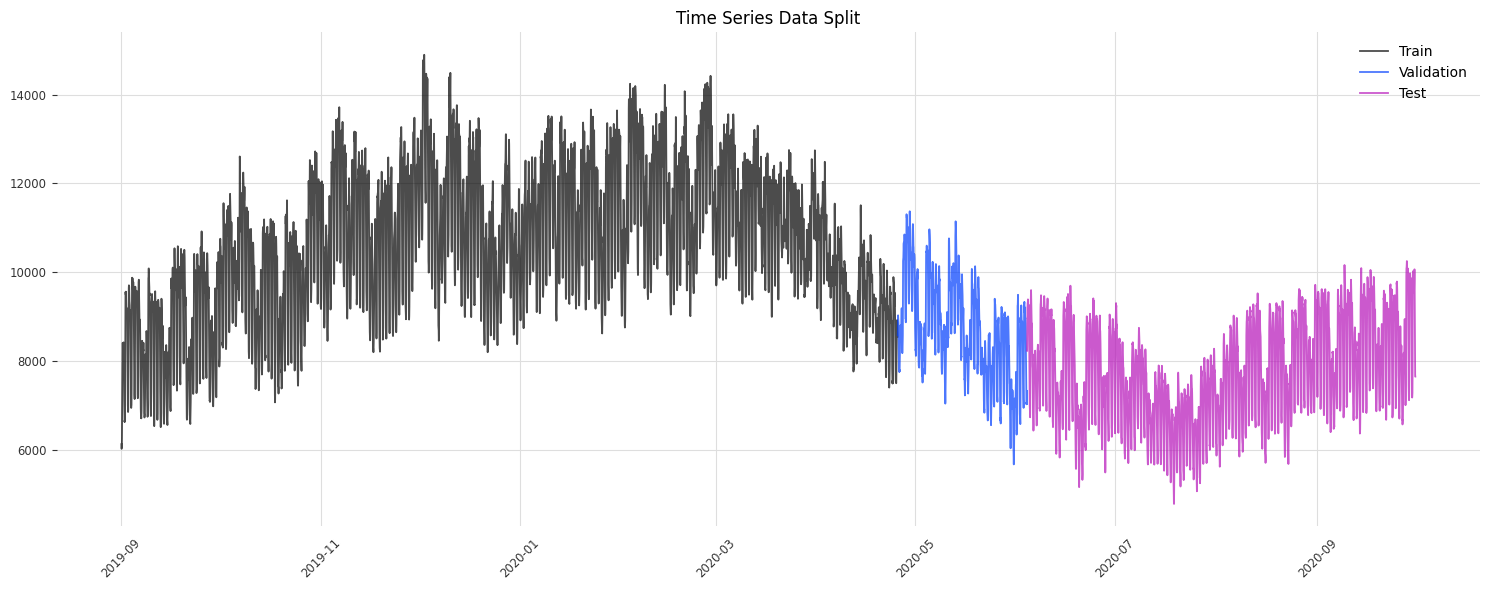

In [38]:
data_handler_imp = TimeSeriesTrainTest(df_imp, target_col='load_actual')
train_data_imp, val_data_imp, test_data_imp = data_handler_imp.temporal_split()

### 2. SARIMA

Statistical model, good baseline, captures trends/seasonality. Since the electricity data has some kind of cycle, we use SARIMA as the baseline.

In [39]:
class SARIMAForecast:
    """
    SARIMA model for time series forecasting
    """

    def __init__(self, order=(1,1,1), seasonal_order=(1,1,1,24)):
        self.model = None
        self.model_fit = None
        self.order = order
        self.seasonal_order = seasonal_order

    def fit(self, train_data, target_col='load_actual'):
        """
        Fit SARIMA model
        """
        series = train_data[target_col].dropna()

        # Fit model
        self.model = ARIMA(
            series,
            order=self.order,
            seasonal_order=self.seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
            )

        self.model_fit = self.model.fit()

        print(self.model_fit.summary())

        print("Training SARIMA done")
        return self

    def forecast_rolling(self, test_data, target_col='load_actual', forecast_horizon=24):
        """
        Rolling forecast (refit model for each prediction)
        """
        print(f"SARIMA Rolling Forecast (horizon: {forecast_horizon} hours)")

        predictions = []
        actuals = []

        # Get initial training data
        history = list(self.model_fit.model.endog)

        # Use the original fitted model initially
        current_model_fit = self.model_fit

        total_steps = len(test_data) - forecast_horizon + 1
        step_size = forecast_horizon  # Can be adjusted for different strategies

        start_time = time.time()

        for i in range(0, total_steps, step_size):
            step_start_time = time.time()

            # Refit model every 7 days: balances accuracy and computational efficiency
            if i > 0 and i % (24 * 7) == 0:
                model = ARIMA(
                    history,
                    order=self.order,
                    seasonal_order=self.seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                current_model_fit = model.fit(maxiter=50)

            forecast = current_model_fit.forecast(steps=min(forecast_horizon, len(test_data) - i))
            predictions.extend(forecast)

            # Get actual values
            actual = test_data[target_col].iloc[i:i+forecast_horizon].values
            actuals.extend(actual[:len(forecast)])  # Match forecast length

            # Update history with actual values for next iteration
            history.extend(actual[:len(forecast)])

            step_time = time.time() - step_start_time
            elapsed_time = time.time() - start_time

            if i % (forecast_horizon * 7) == 0:  # Print progress every week
                progress = (i + forecast_horizon) / len(test_data) * 100
                estimated_total = elapsed_time / max((i + forecast_horizon), 1) * len(test_data)
                remaining = estimated_total - elapsed_time

                print(f"Forecasted {i + forecast_horizon} / {len(test_data)} hours")
                print(f"\n| Step time: {step_time:.2f}s | ETA: {remaining/60:.1f}min")

        return np.array(predictions), np.array(actuals)

    def forecast_rolling_simple(self, test_data, target_col='load_actual', forecast_horizon=24): # much faster
        """
        Simpler rolling forecast without refitting (much faster)
        """
        print(f"SARIMA Simple Rolling Forecast (horizon: {forecast_horizon} hours)")

        predictions = []
        actuals = []

        # Get the end of training data for extending
        last_obs = self.model_fit.model.endog

        for i in range(0, len(test_data) - forecast_horizon + 1, forecast_horizon):
            # Simple forecast from the original model
            forecast = self.model_fit.forecast(steps=forecast_horizon)
            predictions.extend(forecast)

            # Get actual values
            actual = test_data[target_col].iloc[i:i+forecast_horizon].values
            actuals.extend(actual)

            if i % (forecast_horizon * 7) == 0:  # Progress every week
                progress = (i + forecast_horizon) / len(test_data) * 100
                print(f"Progress: {progress:.1f}% ({i + forecast_horizon}/{len(test_data)} hours)")

        return np.array(predictions), np.array(actuals)

    def forecast_simple(self, n_periods=24):
        """
        Simple forecast without rolling
        """
        return self.model_fit.forecast(steps=n_periods)

In [40]:
def run_sarima_forecast():
    try:
        print("Initializing SARIMA model...")
        sarima_model = SARIMAForecast(order=(1,1,1), seasonal_order=(1,1,1,24))

        print("Fitting SARIMA model...")
        sarima_model.fit(train_data_imp, target_col='load_actual')

        print("Starting rolling forecast...")
        # Try the simpler version first (much faster)
        sarima_pred, sarima_actual = sarima_model.forecast_rolling_simple(
            test_data_imp, target_col='load_actual', forecast_horizon=24
        )

        # # If you need the more sophisticated rolling forecast with refitting:
        # sarima_pred, sarima_actual = sarima_model.forecast_rolling(
        #     test_data_imp, target_col='load_actual', forecast_horizon=24
        # )

        print("Evaluating forecasts...")
        sarima_metrics = evaluate_forecasts(sarima_pred, sarima_actual, "SARIMA")

        print("Plotting results...")
        plot_forecasts(sarima_pred, sarima_actual, "SARIMA")

        return sarima_model, sarima_pred, sarima_actual, sarima_metrics

    except Exception as e:
        print(f"Error in SARIMA forecast: {e}")
        return None, None, None, None

Initializing SARIMA model...
Fitting SARIMA model...
                                    SARIMAX Results                                     
Dep. Variable:                      load_actual   No. Observations:                 5702
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -36244.668
Date:                          Sun, 14 Sep 2025   AIC                          72499.337
Time:                                  17:35:40   BIC                          72532.534
Sample:                              09-01-2019   HQIC                         72510.900
                                   - 04-25-2020                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2344      0.016     14.223      0.000       0.202       0.26

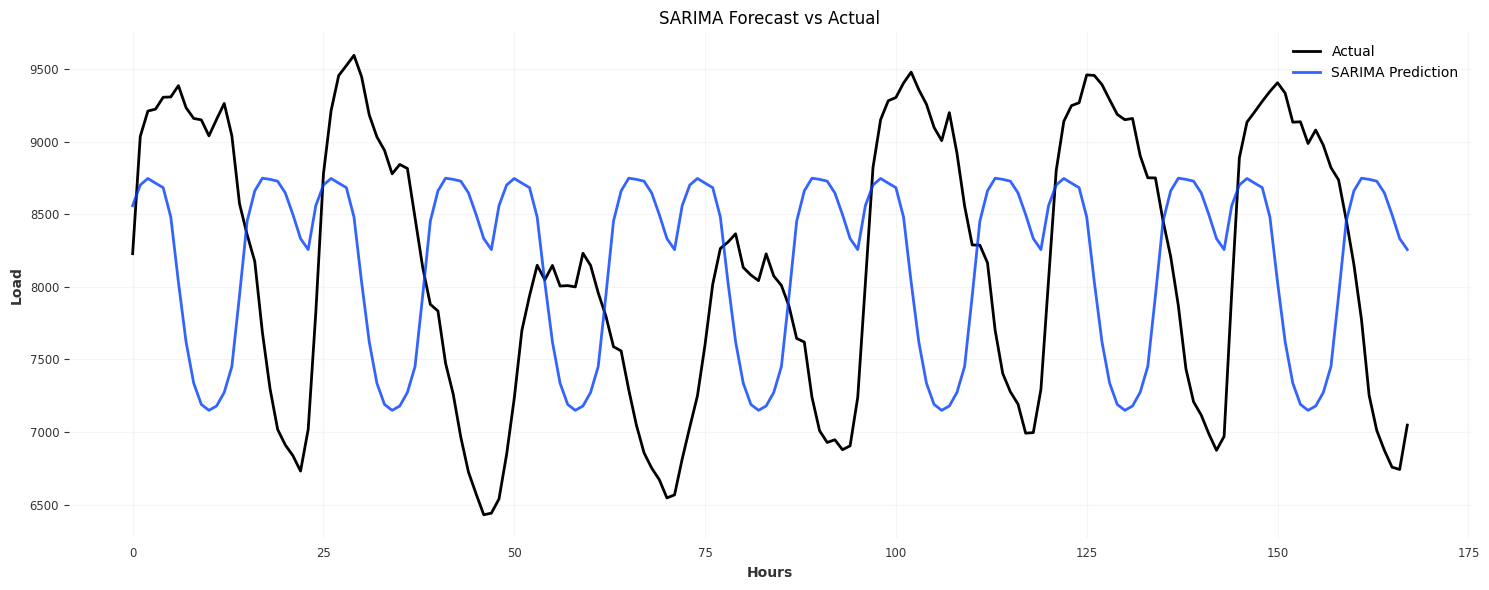

In [41]:
# Run the forecast
sarima_model, sarima_pred, sarima_actual, sarima_metrics = run_sarima_forecast()

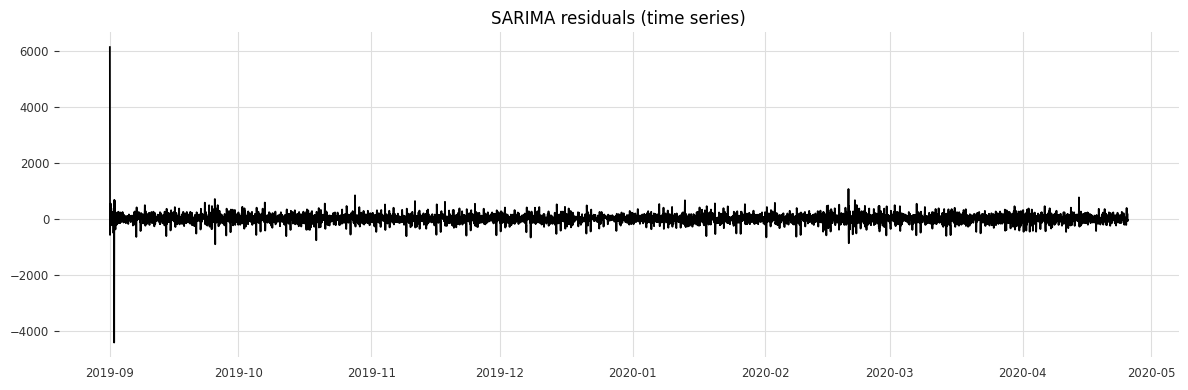

In [42]:
resid = sarima_model.model_fit.resid  # the fitted statsmodels results object
plt.figure(figsize=(12,4))
plt.plot(resid)
plt.title('SARIMA residuals (time series)')
plt.tight_layout()
plt.show()

<Figure size 800x300 with 0 Axes>

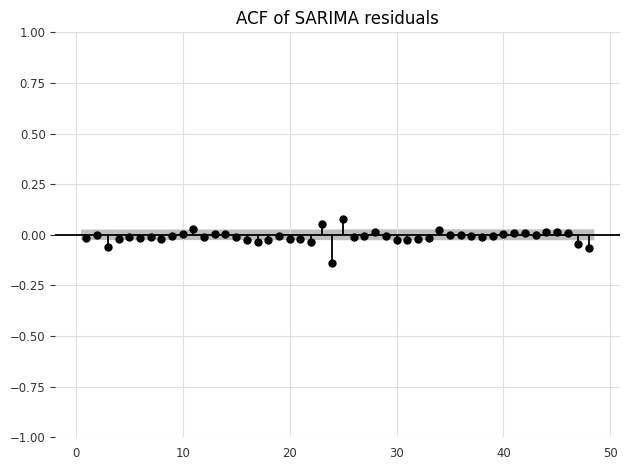

In [43]:
plt.figure(figsize=(8,3))
plot_acf(resid.dropna(), lags=48, zero=False)
plt.title('ACF of SARIMA residuals')
plt.tight_layout()
plt.show()

### 3. N-BEATS: Neural network designed for forecasting, handles complex patterns

*Using KERAS*

Keras version gives easy multi-step forecasting, with preprocessing and training handled automatically, better for applied forecasting pipelines. However, if we are in a research or experimenting with complex architectures, PyTorch version gives full manual control.

In [44]:
class NBEATSForecast:
    """
    N-BEATS neural network for forecasting using Darts wrapper
    """

    def __init__(self,
                 input_chunk_length=24*7,
                 output_chunk_length=24,
                 num_stacks=3, # Reduced version from 30 to 3
                 num_blocks=1,
                 num_layers=4,
                 layer_widths=64, # Reduced version from 512 to 64
                 dropout=0.1):

        self.input_chunk_length = input_chunk_length
        self.output_chunk_length = output_chunk_length

        self.model = NBEATSModel(
            input_chunk_length=input_chunk_length,
            output_chunk_length=output_chunk_length,
            num_stacks=num_stacks,
            num_blocks=num_blocks,
            num_layers=num_layers,
            layer_widths=layer_widths,
            expansion_coefficient_dim=5,
            trend_polynomial_degree=2,
            dropout=dropout,
            activation="ReLU",
            random_state=42,
            pl_trainer_kwargs={
                "accelerator": "auto",
                "devices": 1,
                "enable_progress_bar": True,
                "max_epochs": 100
            }
        )

    def fit(self, train_data, val_data, target_col='load_actual', epochs=10): # Reduced epoch for demo
        """
        Train N-BEATS model
        """
        print("Training N-BEATS")

        # Prepare data
        train_data = train_data.copy()
        val_data = val_data.copy()

        # Remove timezone info to avoid warnings
        if hasattr(train_data.index, 'tz') and train_data.index.tz is not None:
            train_data.index = train_data.index.tz_localize(None)
        if hasattr(val_data.index, 'tz') and val_data.index.tz is not None:
            val_data.index = val_data.index.tz_localize(None)

        # Convert to Darts TimeSeries (only target column)
        train_ts = TimeSeries.from_dataframe(
            train_data[[target_col]],
            value_cols=target_col
        )

        val_ts = TimeSeries.from_dataframe(
            val_data[[target_col]],
            value_cols=target_col
        )

        # Update the trainer kwargs before fitting
        if hasattr(self.model, 'pl_trainer_kwargs'):
            self.model.pl_trainer_kwargs['max_epochs'] = epochs
        else:
            # For older versions of Darts, recreate the model with updated epochs
            self.model = NBEATSModel(
                input_chunk_length=self.input_chunk_length,
                output_chunk_length=self.output_chunk_length,
                num_stacks=30,
                num_blocks=1,
                num_layers=4,
                layer_widths=512,
                expansion_coefficient_dim=5,
                trend_polynomial_degree=2,
                dropout=0.1,
                activation="ReLU",
                random_state=42,
                pl_trainer_kwargs={
                    "accelerator": "auto",
                    "devices": 1,
                    "enable_progress_bar": True,
                    "max_epochs": epochs
                }
            )

        self.model.fit(
            series=train_ts,
            val_series=val_ts,
            verbose=True
        )

        print("Darts N-BEATS model trained successfully")

        return self

    def forecast_rolling(self, test_data, target_col='load_actual', train_tail=None):
        """
        Rolling forecast with N-BEATS
        """
        print("=== N-BEATS Rolling Forecast ===")

        test_data = test_data.copy()

        # Ensure datetime index and remove timezone
        if not isinstance(test_data.index, pd.DatetimeIndex):
            test_data.index = pd.to_datetime(test_data.index)
        if hasattr(test_data.index, 'tz') and test_data.index.tz is not None:
            test_data.index = test_data.index.tz_localize(None)

        # Convert to Darts TimeSeries
        test_ts = TimeSeries.from_dataframe(
            test_data.reset_index(),
            time_col=test_data.index.name or 'time',
            value_cols=target_col
        )

        # Prepare historical context
        historical_ts = None
        if train_tail is not None:
            train_tail = train_tail.copy()

            # Take only the last part of training data that we need for context
            context_length = max(self.input_chunk_length, 24*14)  # At least 2 weeks
            if len(train_tail) > context_length:
                train_tail = train_tail.tail(context_length)

            # Ensure datetime index and remove timezone
            if not isinstance(train_tail.index, pd.DatetimeIndex):
                train_tail.index = pd.to_datetime(train_tail.index)
            if hasattr(train_tail.index, 'tz') and train_tail.index.tz is not None:
                train_tail.index = train_tail.index.tz_localize(None)

            historical_ts = TimeSeries.from_dataframe(
                train_tail.reset_index(),
                time_col=train_tail.index.name or 'time',
                value_cols=target_col
            )

        predictions = []
        actuals = []

        # Rolling forecast
        n_forecasts = len(test_data) // self.output_chunk_length

        for i in range(n_forecasts):
            start_idx = i * self.output_chunk_length
            end_idx = min(start_idx + self.output_chunk_length, len(test_data))

            print(f"Forecast {i+1}/{n_forecasts}: predicting steps {start_idx} to {end_idx-1}")

            # Prepare context series for prediction
            if historical_ts is not None:
                if start_idx == 0:
                    # First prediction: use historical context
                    context_series = historical_ts
                else:
                    # Subsequent predictions: use historical + previous test data
                    previous_test_data = test_data.iloc[:start_idx]

                    # Remove timezone from previous test data
                    if hasattr(previous_test_data.index, 'tz') and previous_test_data.index.tz is not None:
                        previous_test_data.index = previous_test_data.index.tz_localize(None)

                    previous_test_ts = TimeSeries.from_dataframe(
                        previous_test_data.reset_index(),
                        time_col=previous_test_data.index.name or 'time',
                        value_cols=target_col
                    )
                    context_series = historical_ts.concatenate(previous_test_ts, ignore_time_axis=True)
            else:
                # No historical context - use available test data
                if start_idx < self.input_chunk_length:
                    print(f"Warning: Not enough context for prediction {i+1}. Skipping.")
                    continue

                context_data = test_data.iloc[:start_idx]
                context_series = TimeSeries.from_dataframe(
                    context_data.reset_index(),
                    time_col=context_data.index.name or 'time',
                    value_cols=target_col
                )

            # Check if we have enough context
            if len(context_series) < self.input_chunk_length:
                print(f"Warning: Insufficient context length {len(context_series)} < {self.input_chunk_length}")
                continue

            # Make prediction
            n_predict = end_idx - start_idx
            forecast = self.model.predict(
                n=n_predict,
                series=context_series
            )

            pred_values = forecast.values().flatten()
            predictions.extend(pred_values)

            # Get actual values
            actual_values = test_data[target_col].iloc[start_idx:end_idx].values
            actuals.extend(actual_values)

        print(f"Generated {len(predictions)} predictions and {len(actuals)} actuals")
        return np.array(predictions), np.array(actuals)

    def forecast_simple(self, test_data, target_col='load_actual', n_periods=24):
        """
        Simple forecast for n_periods ahead
        """
        print(f"N-BEATS Simple Forecast ({n_periods} periods)")

        test_data = test_data.copy()
        if not isinstance(test_data.index, pd.DatetimeIndex):
            test_data.index = pd.to_datetime(test_data.index)
        if hasattr(test_data.index, 'tz') and test_data.index.tz is not None:
            test_data.index = test_data.index.tz_localize(None)

        # Use the last part of test_data as context
        context_length = min(self.input_chunk_length, len(test_data))
        context_data = test_data.tail(context_length)

        context_ts = TimeSeries.from_dataframe(
            context_data.reset_index(),
            time_col=context_data.index.name or 'time',
            value_cols=target_col
        )

        forecast = self.model.predict(n=n_periods, series=context_ts)
        return forecast.values().flatten()


In [45]:
def run_nbeats_forecast():
    """
    Run N-BEATS forecast with error handling
    """
    try:
        print("Initializing N-BEATS model...")
        nbeats_model = NBEATSForecast(
            input_chunk_length=24*7,
            output_chunk_length=24,
            num_stacks=3,        # Reduced version from 30 to 3
            layer_widths=64      # Reduced version from 512 to 64
        )

        print("Fitting N-BEATS model...")
        nbeats_model.fit(
            train_data_imp,
            val_data_imp,
            target_col='load_actual',
            epochs=10 # Reduced version
        )
        gc.collect() # Free up memory after training

        print("Starting rolling forecast...")
        nbeats_pred, nbeats_actual = nbeats_model.forecast_rolling(
            test_data_imp,
            target_col='load_actual',
            train_tail=train_data_imp
        )

        if len(nbeats_pred) > 0 and len(nbeats_actual) > 0:
            print("Evaluating forecasts...")
            nbeats_metrics = evaluate_forecasts(nbeats_pred, nbeats_actual, "N-BEATS")

            print("Plotting results...")
            plot_forecasts(nbeats_pred, nbeats_actual, "N-BEATS")

            return nbeats_model, nbeats_pred, nbeats_actual, nbeats_metrics
        else:
            print("No predictions generated!")
            return None, None, None, None

    except Exception as e:
        print(f"Error in N-BEATS forecast: {e}")
        print(f"Error type: {type(e).__name__}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

Initializing N-BEATS model...
Fitting N-BEATS model...
Training N-BEATS


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 26.4 M | train
-------------------------------------------------------------
26.4 M    Trainable params
3.6 K     Non-trainable params
26.4 M    Total params
211.387   Total estimated m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Darts N-BEATS model trained successfully
Starting rolling forecast...
=== N-BEATS Rolling Forecast ===
Forecast 1/118: predicting steps 0 to 23


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 2/118: predicting steps 24 to 47


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 3/118: predicting steps 48 to 71


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 4/118: predicting steps 72 to 95


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 5/118: predicting steps 96 to 119


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 6/118: predicting steps 120 to 143


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 7/118: predicting steps 144 to 167


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 8/118: predicting steps 168 to 191


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 9/118: predicting steps 192 to 215


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 10/118: predicting steps 216 to 239


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 11/118: predicting steps 240 to 263


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 12/118: predicting steps 264 to 287


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 13/118: predicting steps 288 to 311


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 14/118: predicting steps 312 to 335


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 15/118: predicting steps 336 to 359


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 16/118: predicting steps 360 to 383


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 17/118: predicting steps 384 to 407


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 18/118: predicting steps 408 to 431


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 19/118: predicting steps 432 to 455


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 20/118: predicting steps 456 to 479


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 21/118: predicting steps 480 to 503


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 22/118: predicting steps 504 to 527


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 23/118: predicting steps 528 to 551


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 24/118: predicting steps 552 to 575


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 25/118: predicting steps 576 to 599


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 26/118: predicting steps 600 to 623


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 27/118: predicting steps 624 to 647


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 28/118: predicting steps 648 to 671


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 29/118: predicting steps 672 to 695


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 30/118: predicting steps 696 to 719


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 31/118: predicting steps 720 to 743


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 32/118: predicting steps 744 to 767


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 33/118: predicting steps 768 to 791


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 34/118: predicting steps 792 to 815


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 35/118: predicting steps 816 to 839


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 36/118: predicting steps 840 to 863


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 37/118: predicting steps 864 to 887


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 38/118: predicting steps 888 to 911


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 39/118: predicting steps 912 to 935


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 40/118: predicting steps 936 to 959


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 41/118: predicting steps 960 to 983


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 42/118: predicting steps 984 to 1007


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 43/118: predicting steps 1008 to 1031


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 44/118: predicting steps 1032 to 1055


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 45/118: predicting steps 1056 to 1079


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 46/118: predicting steps 1080 to 1103


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 47/118: predicting steps 1104 to 1127


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 48/118: predicting steps 1128 to 1151


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 49/118: predicting steps 1152 to 1175


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 50/118: predicting steps 1176 to 1199


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 51/118: predicting steps 1200 to 1223


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 52/118: predicting steps 1224 to 1247


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 53/118: predicting steps 1248 to 1271


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 54/118: predicting steps 1272 to 1295


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 55/118: predicting steps 1296 to 1319


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 56/118: predicting steps 1320 to 1343


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 57/118: predicting steps 1344 to 1367


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 58/118: predicting steps 1368 to 1391


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 59/118: predicting steps 1392 to 1415


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 60/118: predicting steps 1416 to 1439


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 61/118: predicting steps 1440 to 1463


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 62/118: predicting steps 1464 to 1487


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 63/118: predicting steps 1488 to 1511


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 64/118: predicting steps 1512 to 1535


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 65/118: predicting steps 1536 to 1559


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 66/118: predicting steps 1560 to 1583


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 67/118: predicting steps 1584 to 1607


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 68/118: predicting steps 1608 to 1631


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 69/118: predicting steps 1632 to 1655


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 70/118: predicting steps 1656 to 1679


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 71/118: predicting steps 1680 to 1703


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 72/118: predicting steps 1704 to 1727


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 73/118: predicting steps 1728 to 1751


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 74/118: predicting steps 1752 to 1775


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 75/118: predicting steps 1776 to 1799


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 76/118: predicting steps 1800 to 1823


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 77/118: predicting steps 1824 to 1847


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 78/118: predicting steps 1848 to 1871


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 79/118: predicting steps 1872 to 1895


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 80/118: predicting steps 1896 to 1919


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 81/118: predicting steps 1920 to 1943


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 82/118: predicting steps 1944 to 1967


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 83/118: predicting steps 1968 to 1991


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 84/118: predicting steps 1992 to 2015


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 85/118: predicting steps 2016 to 2039


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 86/118: predicting steps 2040 to 2063


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 87/118: predicting steps 2064 to 2087


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 88/118: predicting steps 2088 to 2111


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 89/118: predicting steps 2112 to 2135


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 90/118: predicting steps 2136 to 2159


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 91/118: predicting steps 2160 to 2183


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 92/118: predicting steps 2184 to 2207


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 93/118: predicting steps 2208 to 2231


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 94/118: predicting steps 2232 to 2255


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 95/118: predicting steps 2256 to 2279


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 96/118: predicting steps 2280 to 2303


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 97/118: predicting steps 2304 to 2327


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 98/118: predicting steps 2328 to 2351


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 99/118: predicting steps 2352 to 2375


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 100/118: predicting steps 2376 to 2399


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 101/118: predicting steps 2400 to 2423


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 102/118: predicting steps 2424 to 2447


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 103/118: predicting steps 2448 to 2471


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 104/118: predicting steps 2472 to 2495


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 105/118: predicting steps 2496 to 2519


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 106/118: predicting steps 2520 to 2543


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 107/118: predicting steps 2544 to 2567


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 108/118: predicting steps 2568 to 2591


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 109/118: predicting steps 2592 to 2615


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 110/118: predicting steps 2616 to 2639


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 111/118: predicting steps 2640 to 2663


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 112/118: predicting steps 2664 to 2687


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 113/118: predicting steps 2688 to 2711


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 114/118: predicting steps 2712 to 2735


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 115/118: predicting steps 2736 to 2759


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 116/118: predicting steps 2760 to 2783


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 117/118: predicting steps 2784 to 2807


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast 118/118: predicting steps 2808 to 2831


Predicting: |          | 0/? [00:00<?, ?it/s]

Generated 2832 predictions and 2832 actuals
Evaluating forecasts...

N-BEATS Performance:
  MAE:  337.21
  RMSE: 461.05
  MAPE: 4.29%
Plotting results...


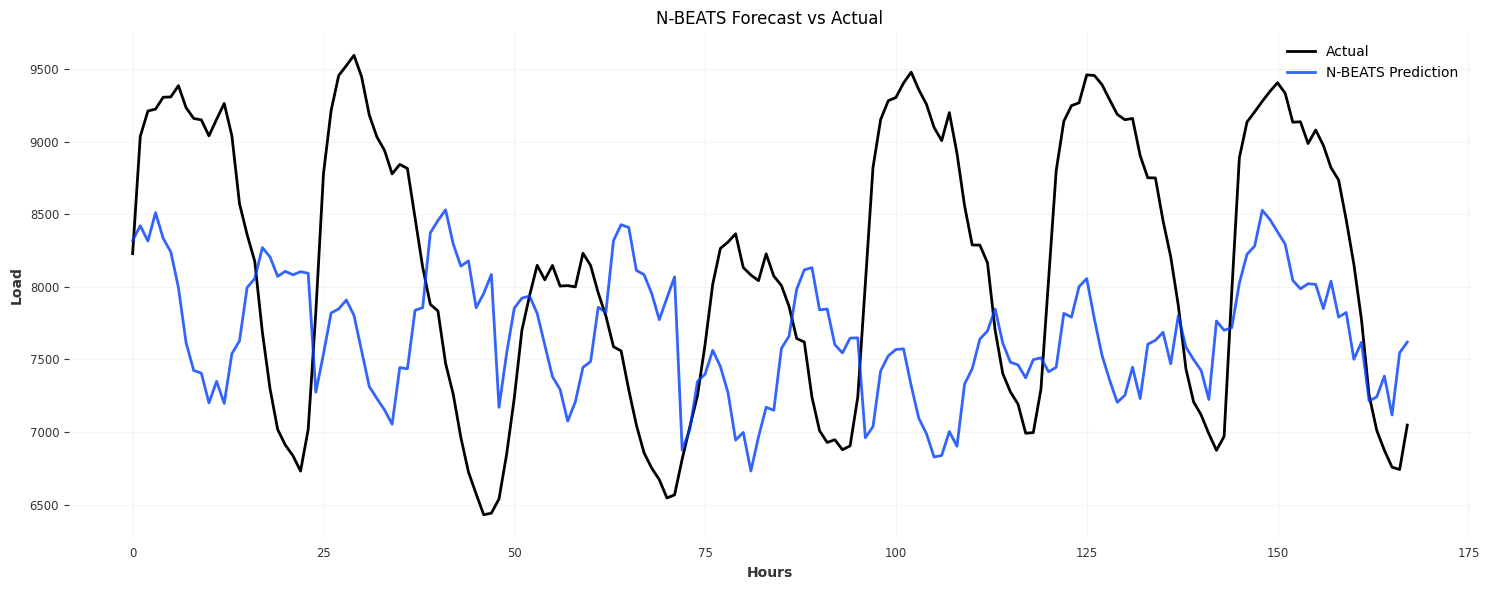

In [46]:
nbeats_model, nbeats_pred, nbeats_actual, nbeats_metrics = run_nbeats_forecast()

### LSTM: RNN for sequential data, captures long-term dependencies

*Using KERAS/TF LSTM*

Keras version gives easy multi-step forecasting, with preprocessing and training handled automatically, better for applied forecasting pipelines. However, if we are in a research or experimenting with complex architectures, PyTorch version gives full manual control.

This model utilize "multi-steps" (forecast_horizon). Comparison between single step and multi steps:<br>
**1. One-step-ahead prediction (recursive / iterated)**
How it works:
- Model predicts one timestep ahead.
- Feed that prediction as input to predict the next timestep.
- Repeat until you reach your forecast horizon.

Pros:
- Simpler model — only needs to learn one-step dynamics.
- Often easier to train, less prone to exploding errors in training.
- Works well if the series is smooth or stationary.

Cons:
- Errors accumulate (propagate) over multiple steps — a small mistake in early predictions can ruin later steps.
- Prediction distribution may drift from reality over long horizons.

Use case:
- Short-term forecasts.
- When the system dynamics are fairly stable and predictable.

**2. Multi-step prediction at each step (direct + rolling)**
How it works:
- Model predicts multiple steps at each time step, potentially with overlapping windows.
- Can be thought of as a hybrid: each forecast covers multiple steps, but you also move forward in time.

Pros:
- Balances flexibility and horizon coverage.
- Can learn inter-step correlations better than simple recursive one-step.

Cons:
- Even harder to train.
- Can be computationally expensive if horizon is long.


In our case, we choose **Multi-step** for some reasons:
1. Energy Load Forecasting: You need to predict daily patterns (24 hours), so learning the full daily cycle in one shot makes sense
2. Computational Efficiency: Instead of 24 separate model calls, you get 24 predictions in one forward pass
3. Pattern Learning: The model learns to output coordinated daily patterns rather than just next-hour dependencies
4. Less Error Accumulation: Unlike recursive single-step, errors don't compound across the 24-hour horizon

This approach is well-suited for hourly energy forecasting where we need to predict daily demand patterns. The multi-step direct approach is actually more sophisticated and appropriate for your domain than single-step would be.

In [47]:
class LSTMForecast:
    """
    LSTM model for time series forecasting
    """

    def __init__(self, lookback_window=24*7, forecast_horizon=24):
        self.lookback_window = lookback_window
        self.forecast_horizon = forecast_horizon
        self.model = None
        self.scaler = StandardScaler()
        self.target_scaler = StandardScaler()
        self.history = None

    def create_model(self, input_dim):
        """
        Create LSTM model
        """

        model = Sequential([
            LSTM(16, return_sequences=False, input_shape=(self.lookback_window, input_dim)),
            Dropout(0.3),
            Dense(8, activation='relu'),
            Dense(self.forecast_horizon)
        ])

        model.compile(optimizer=Adam(learning_rate=0.001,
                                     clipnorm=1.0), # gradient clipping
                     loss='mse',
                     metrics=['mae']
                     )

        return model

    def fit(self, train_data, val_data, target_col='load_actual', epochs=50):
        """
        Train LSTM model
        """
        print("=== TRAINING LSTM MODEL ===")

        # Create sequences
        data_handler = TimeSeriesTrainTest(pd.concat([train_data, val_data]))
        X_train, y_train = data_handler.create_sequences(
            train_data, self.lookback_window, self.forecast_horizon
        )
        X_val, y_val = data_handler.create_sequences(
            val_data, self.lookback_window, self.forecast_horizon
        )

        target_col_idx = list(train_data.columns).index(target_col)
        feature_indices = [i for i in range(len(train_data.columns)) if i != target_col_idx]

        X_train = X_train[:, :, feature_indices]
        X_val = X_val[:, :, feature_indices]

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        X_val_scaled = self.scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

        # Scale target - fix the reshaping issue
        y_train_flat = y_train.reshape(-1, 1)
        y_val_flat = y_val.reshape(-1, 1)

        self.target_scaler.fit(y_train_flat)
        y_train_scaled = self.target_scaler.transform(y_train_flat).reshape(y_train.shape)
        y_val_scaled = self.target_scaler.transform(y_val_flat).reshape(y_val.shape)

        # Create and train model
        self.model = self.create_model(X_train.shape[-1])

        callbacks = [
            EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
            ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-7),
            ModelCheckpoint('lstm_best_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
        ]

        history = self.model.fit(X_train_scaled, y_train_scaled,
                                 validation_data=(X_val_scaled, y_val_scaled),
                                 epochs=epochs,
                                 batch_size=32, # Reduced version from 64 to 32
                                 verbose=1,
                                 callbacks=callbacks)

        self.history = history.history

        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.title('LSTM Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Train')
        plt.plot(history.history['val_mae'], label='Validation')
        plt.title('LSTM MAE')
        plt.legend()
        plt.tight_layout()
        plt.show()

        return self

    def forecast_rolling(self, test_data, target_col='load_actual', train_tail=None):
        """
        Rolling forecast with LSTM
        """
        print("=== LSTM ROLLING FORECAST ===")

        try:
            predictions = []
            actuals = []

            # Remove target column from features
            feature_cols = [col for col in test_data.columns if col != target_col]

            # If train_tail is provided, use it for initial context
            if train_tail is not None:
                # Ensure we have the same feature columns in train_tail
                train_tail_features = [col for col in train_tail.columns if col != target_col]
                initial_context = train_tail[train_tail_features].iloc[-self.lookback_window:]
            else:
                initial_context = None


            total_iterations = len(test_data) - self.forecast_horizon + 1
            print(f"Expected iterations: {total_iterations}")
            if total_iterations <= 0:
                print("Error: Not enough test data for even one forecast!")
                return np.array([]), np.array([])

            for i in range(0, len(test_data) - self.forecast_horizon + 1, self.forecast_horizon):
                # Prepare input sequence
                if i == 0 and initial_context is not None:
                    lookback_data = initial_context
                else:
                    # Use sliding window from test data
                    # Always use available history, pad with initial_context if needed
                    start_idx = max(0, i - self.lookback_window)
                    if start_idx == 0 and initial_context is not None:
                        # Combine initial context with early test data
                        available_test = test_data[feature_cols].iloc[:i]
                        needed_from_context = self.lookback_window - len(available_test)
                        if needed_from_context > 0:
                            lookback_data = pd.concat([
                                initial_context.tail(needed_from_context),
                                available_test
                            ])
                        else:
                            lookback_data = available_test.tail(self.lookback_window)
                    else:
                        lookback_data = test_data[feature_cols].iloc[start_idx:i]

                # Ensure enough rows / safety check
                if len(lookback_data) < self.lookback_window:
                    print(f"Warning: Insufficient lookback data at step {i}")
                    continue

                # Check for NaN values
                if lookback_data.isnull().any().any():
                    print(f"Warning: NaN values detected at step {i}")
                    continue

                # Add this validation:
                if lookback_data.shape[1] != len(feature_cols):
                    print(f"Warning: Feature dimension mismatch at step {i}: expected {len(feature_cols)}, got {lookback_data.shape[1]}")
                    continue

                X_pred = lookback_data.values.reshape(1, self.lookback_window, -1)
                X_pred_scaled = self.scaler.transform(X_pred.reshape(-1, X_pred.shape[-1])).reshape(X_pred.shape)

                # Make prediction
                pred_scaled = self.model.predict(X_pred_scaled, verbose=0)[0]
                pred = self.target_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).reshape(-1)
                predictions.extend(pred)

                # Get actual values
                actual = test_data[target_col].iloc[i:i+self.forecast_horizon].values
                actuals.extend(actual)

                if i % (self.forecast_horizon * 7) == 0:  # Progress every week
                    progress = (i + self.forecast_horizon) / len(test_data) * 100
                    print(f"LSTM Progress: {progress:.1f}% ({i + self.forecast_horizon}/{len(test_data)} hours)")

            min_len = min(len(predictions), len(actuals))
            if min_len < len(predictions) or min_len < len(actuals):
                predictions = predictions[:min_len]
                actuals = actuals[:min_len]

            print(f"Generated {len(predictions)} predictions and {len(actuals)} actuals")
            return np.array(predictions), np.array(actuals)

        except Exception as e:
            return np.array([]), np.array([])

=== TRAINING LSTM MODEL ===
Epoch 1/30
174/176 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9889 - mae: 0.8245
Epoch 1: val_loss improved from inf to 1.84997, saving model to lstm_best_model.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.9890 - mae: 0.8245 - val_loss: 1.8500 - val_mae: 1.2007 - learning_rate: 0.0010
Epoch 2/30
174/176 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9723 - mae: 0.8175
Epoch 2: val_loss improved from 1.84997 to 1.72646, saving model to lstm_best_model.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9724 - mae: 0.8175 - val_loss: 1.7265 - val_mae: 1.1583 - learning_rate: 0.0010
Epoch 3/30
171/176 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8860 - mae: 0.7795
Epoch 3: val_loss improved from 1.72646 to 1.29041, saving model to lstm_best_model.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8850 - mae: 0.7791 - val_loss: 1.2904 - val_mae: 0.9762 - learning_rate: 0.0010
Epoch 4/30
172/176 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8045 - mae: 0.7394
Epoch 4: val_loss did not improve from 1.29041
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8040 - mae: 0.7392 - val_loss: 1.2981 - val_mae: 0.9820 - learning_rate: 0.0010
Epoch 5/30
174/176 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7603 - mae: 0.7205
Epoch 5: val_loss did not improve from 1.29041
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7601 - mae: 0.7204 - val_loss: 1.3785 - val_mae: 1.0082 - learning_rate: 0.0010
Epoch 6/30
172/176 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7274 - mae: 0.7042
Epoch 6: val_loss improved from 1.29041 to 1.14033, saving model to lstm_best_model.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7272 - mae: 0.7041 - val_loss: 1.1403 - val_mae: 0.8959 - learning_rate: 0.0010
Epoch 7/30
173/176 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6900 - mae: 0.6856
Epoch 7: val_loss did not improve from 1.14033
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.6899 - mae: 0.6855 - val_loss: 1.4101 - val_mae: 1.0216 - learning_rate: 0.0010
Epoch 8/30
174/176 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6903 - mae: 0.6829
Epoch 8: val_loss did not improve from 1.14033
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.6901 - mae: 0.6828 - val_loss: 1.3591 - val_mae: 0.9907 - learning_rate: 0.0010
Epoch 9/30
172/176 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6729 - mae: 0.6737
Epoch 9: val_loss did not improve from 1.14033
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.6728 - mae: 0.6737 - val_loss: 1.4463 - val_mae: 1.0430 - learning_rate: 0.0010
Epoch 10/30
173/176 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6487 - mae: 0.6608
Epoch 10

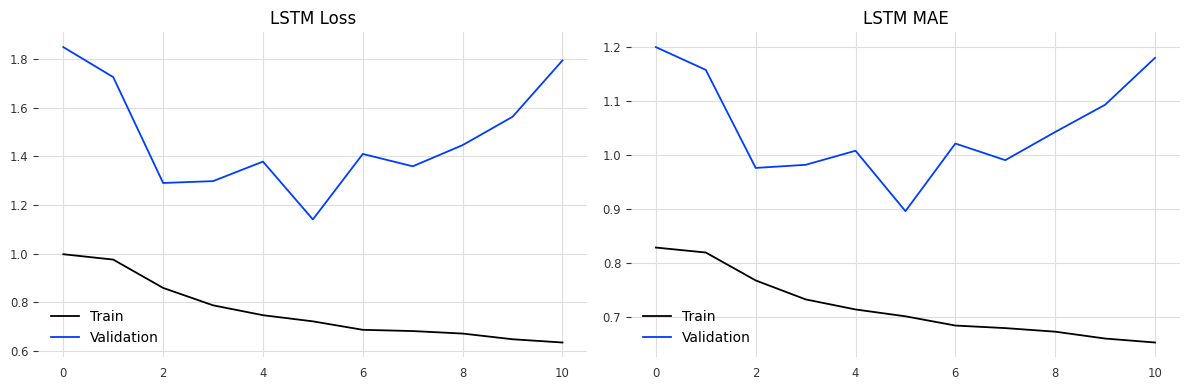

=== LSTM ROLLING FORECAST ===
Expected iterations: 2829
LSTM Progress: 0.8% (24/2852 hours)
LSTM Progress: 6.7% (192/2852 hours)
LSTM Progress: 12.6% (360/2852 hours)
LSTM Progress: 18.5% (528/2852 hours)
LSTM Progress: 24.4% (696/2852 hours)
LSTM Progress: 30.3% (864/2852 hours)
LSTM Progress: 36.2% (1032/2852 hours)
LSTM Progress: 42.1% (1200/2852 hours)
LSTM Progress: 48.0% (1368/2852 hours)
LSTM Progress: 53.9% (1536/2852 hours)
LSTM Progress: 59.7% (1704/2852 hours)
LSTM Progress: 65.6% (1872/2852 hours)
LSTM Progress: 71.5% (2040/2852 hours)
LSTM Progress: 77.4% (2208/2852 hours)
LSTM Progress: 83.3% (2376/2852 hours)
LSTM Progress: 89.2% (2544/2852 hours)
LSTM Progress: 95.1% (2712/2852 hours)
Generated 2832 predictions and 2832 actuals

LSTM Performance:
  MAE:  2511.79
  RMSE: 2718.48
  MAPE: 34.95%


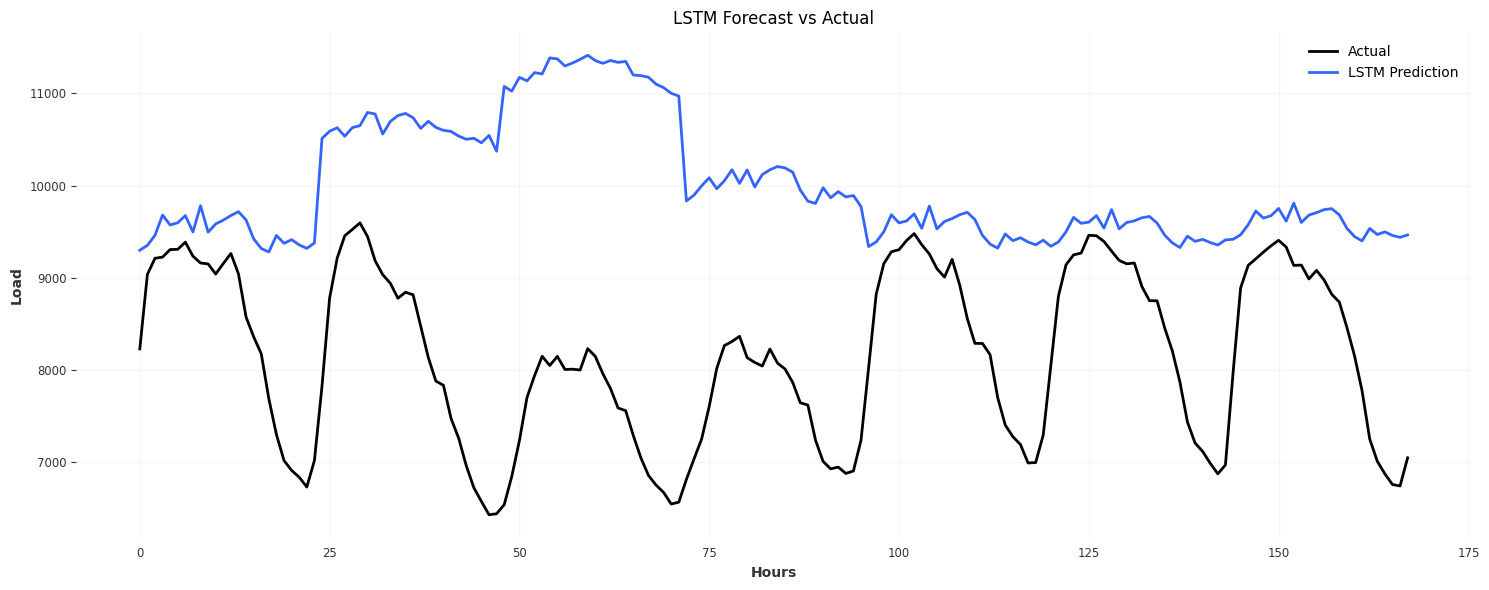

In [48]:
lstm_model = LSTMForecast(lookback_window=24*3)
lstm_model.fit(train_data_imp, val_data_imp, target_col='load_actual', epochs=30) # Reduced for demo

gc.collect()
lstm_pred, lstm_actual = lstm_model.forecast_rolling(test_data_imp, target_col='load_actual', train_tail=train_data_imp)
lstm_metrics = evaluate_forecasts(lstm_pred, lstm_actual, "LSTM")
plot_forecasts(lstm_pred, lstm_actual, "LSTM")

The LSTM is somehow struggling because:

- Energy load data might have simple patterns that don't require deep learning complexity
- Limited feature diversity (only 2-3 features excluding target)
- LSTM architecture is overkill for this specific dataset
- Classical time series methods (like the SARIMA) might be more appropriate

### Rocket: Fast time series classification using random convolutions

*Identify consumption patterns (High/Medium/Low usage periods)*

In [49]:
class TimeSeriesClassifier:
    """
    Time series classification using ROCKET
    """

    def __init__(self, window_size=24*7):
        self.window_size = window_size
        self.rocket = None
        self.classifier = None
        self.label_encoder = None
        self.percentile_25 = None # For training data only, if not provided will be computed below
        self.percentile_75 = None # For training data only, if not provided will be computed below

    def create_classification_data(self, df, target_col='load_actual', train_percentiles=None):
        """
        Create classification dataset from time series
        Example: Classify consumption patterns (High/Medium/Low)
        """
        print("=== CREATING CLASSIFICATION DATASET ===")

        X_class = []
        y_class = []

        # If train_percentiles not provided, compute them (this should only happen for training data)
        if train_percentiles is None:
            self.percentile_25 = np.percentile(df[target_col], 15)
            self.percentile_75 = np.percentile(df[target_col], 85)
        else:
            # Use provided percentiles (for validation/test data)
            self.percentile_25, self.percentile_75 = train_percentiles

        for i in range(0, len(df) - self.window_size + 1, self.window_size // 2):  # 50% overlap
            # Get window of data
            window = df[target_col].iloc[i:i+self.window_size].values

            # Create label based on average consumption / self-define
            avg_consumption = np.mean(window)
            peak_consumption = np.max(window)
            variability = np.std(window)

            # Use both peak and average for better classification
            if peak_consumption > self.percentile_75 and avg_consumption > self.percentile_75:
                label = 'High'
            elif peak_consumption < self.percentile_25 and avg_consumption < self.percentile_25:
                label = 'Low'
            else:
                label = 'Medium'

            X_class.append(window)
            y_class.append(label)

        print(f"Created {len(X_class)} classification samples")
        print(f"Class distribution: \n{pd.Series(y_class).value_counts()}")

        return np.array(X_class), np.array(y_class)

    def fit_rocket(self, X_train, y_train):
        """
        Train ROCKET classifier
        """
        print("Training ROCKET Classifier")

        # Initialize ROCKET
        self.rocket = Rocket()

        # Fit ROCKET and transform training data
        X_train_rocket = X_train[:, np.newaxis, :]  # shape (n_samples, 1, window_size)
        X_rocket = self.rocket.fit_transform(X_train_rocket)

        # Encode labels
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y_train)

        # Train classifier
        self.classifier = RidgeClassifierCV(alphas=np.logspace(-1, 2, 10), cv=3)
        self.classifier.fit(X_rocket, y_encoded)

        print("ROCKET classifier trainng done")
        print(f"Feature dimension after ROCKET: {X_rocket.shape[1]}")

    def predict(self, X_test):
        """
        Make predictions
        """

        # ROCKET predictions
        X_rocket = self.rocket.transform(X_test[:, np.newaxis, :])
        predictions = self.classifier.predict(X_rocket)

        return self.label_encoder.inverse_transform(predictions)

In [50]:
# Split the timeseries into train and test
train_ratio = 0.8
target_col = 'load_actual'
n_train = int(len(df_imp) * train_ratio)
train_df = df_imp.iloc[:n_train].copy()
test_df = df_imp.iloc[n_train:].copy()

classifier = TimeSeriesClassifier(window_size=24*7)
X_train_class, y_train_class = classifier.create_classification_data(
    train_df, target_col=target_col)

# 5. Create test classification data using TRAINING percentiles
X_test_class, y_test_class = classifier.create_classification_data(
    test_df, target_col=target_col, train_percentiles=(classifier.percentile_25, classifier.percentile_75)
)
classifier.fit_rocket(X_train_class, y_train_class)
class_pred = classifier.predict(X_test_class)

print("Classification Results:")
print(classification_report(y_test_class, class_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_class, class_pred))

=== CREATING CLASSIFICATION DATASET ===
Created 89 classification samples
Class distribution: 
Medium    89
Name: count, dtype: int64
=== CREATING CLASSIFICATION DATASET ===
Created 21 classification samples
Class distribution: 
Medium    18
Low        3
Name: count, dtype: int64
Training ROCKET Classifier
ROCKET classifier trainng done
Feature dimension after ROCKET: 20000
Classification Results:
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00         3
      Medium       0.86      1.00      0.92        18

    accuracy                           0.86        21
   macro avg       0.43      0.50      0.46        21
weighted avg       0.73      0.86      0.79        21


Confusion Matrix:
[[ 0  3]
 [ 0 18]]


## Conclusion

Model          MAE         RMSE       MAPE
0   SARIMA  1310.810901  1533.404973  18.318632
1  N-BEATS   337.210661   461.048222   4.285642
2     LSTM  2511.786207  2718.476400  34.953287

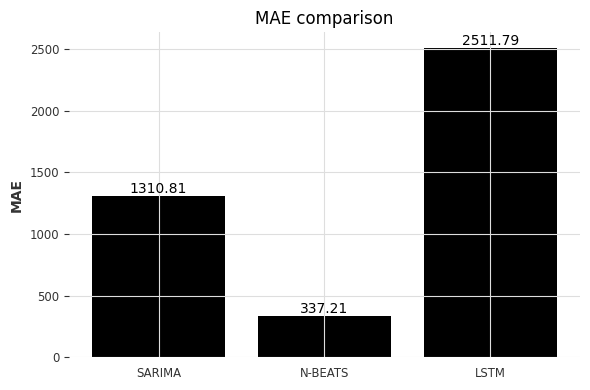

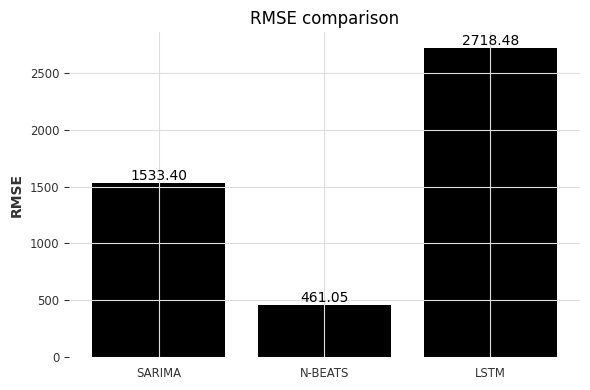

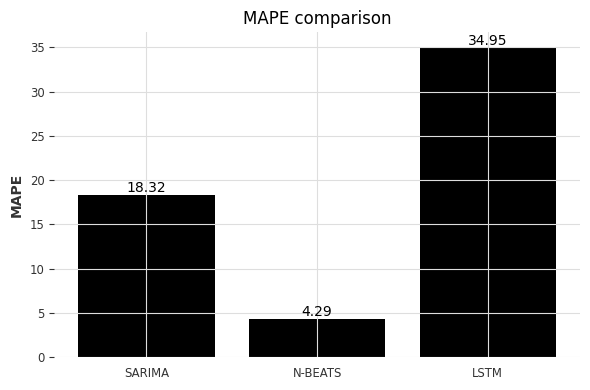

Best model per metric:
{'MAE': 'N-BEATS', 'RMSE': 'N-BEATS', 'MAPE': 'N-BEATS'}


In [51]:
comparison = pd.DataFrame({
    'Model': ['SARIMA', 'N-BEATS', 'LSTM'],
    'MAE': [sarima_metrics['MAE'], nbeats_metrics['MAE'], lstm_metrics['MAE']],
    'RMSE': [sarima_metrics['RMSE'], nbeats_metrics['RMSE'], lstm_metrics['RMSE']],
    'MAPE': [sarima_metrics['MAPE'], nbeats_metrics['MAPE'], lstm_metrics['MAPE']]
})

# Display table
display(comparison)

# Save for reporting
comparison.to_csv('model_comparison_metrics.csv', index=False)

# Bar chart per-metric (one chart per metric)
for metric in ['MAE', 'RMSE', 'MAPE']:
    plt.figure(figsize=(6,4))
    plt.bar(comparison['Model'], comparison[metric])
    plt.title(f'{metric} comparison')
    plt.ylabel(metric)
    for i,v in enumerate(comparison[metric]):
        plt.text(i, v, f"{v:.2f}", ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

# Quick best-per-metric
best = comparison.set_index('Model').idxmin()
print("Best model per metric:")
print(best.to_dict())

In [52]:
def series_from_preds(preds, actuals, test_df, name):
    """
    Align flat preds/actuals arrays to the first len(actuals) timestamps from test_df.
    Returns (pred_series, actual_series)
    """
    n = len(actuals)
    idx = test_df.index[:n]
    preds = np.array(preds)[:n]
    actuals = np.array(actuals)[:n]
    return pd.Series(preds, index=idx, name=name), pd.Series(actuals, index=idx, name='Actual')


In [53]:
sarima_series, actual_series = series_from_preds(sarima_pred, sarima_actual, test_data_imp, "SARIMA")
nbeats_series, _ = series_from_preds(nbeats_pred, nbeats_actual, test_data_imp, "N-BEATS")
lstm_series, _ = series_from_preds(lstm_pred, lstm_actual, test_data_imp, "LSTM")

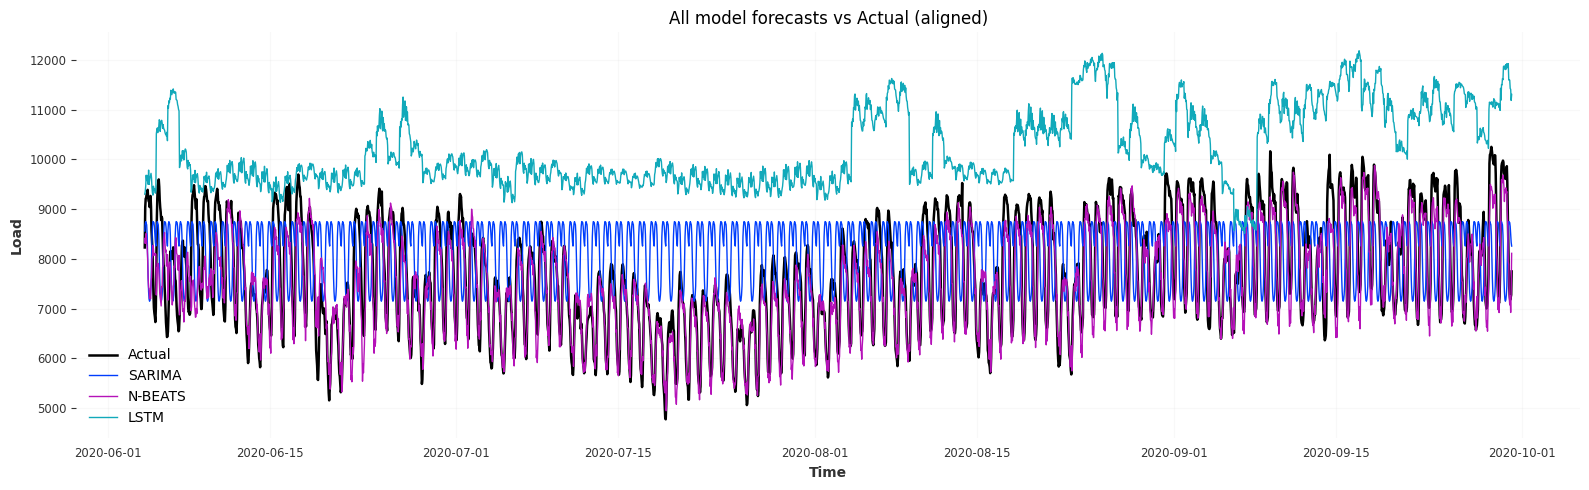

In [54]:
# Overall predictions comparison

plt.figure(figsize=(16,5))
plt.plot(actual_series, label='Actual', linewidth=1.8)
plt.plot(sarima_series, label='SARIMA', linewidth=1.0)
plt.plot(nbeats_series, label='N-BEATS', linewidth=1.0)
plt.plot(lstm_series, label='LSTM', linewidth=1.0)
plt.title('All model forecasts vs Actual (aligned)')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

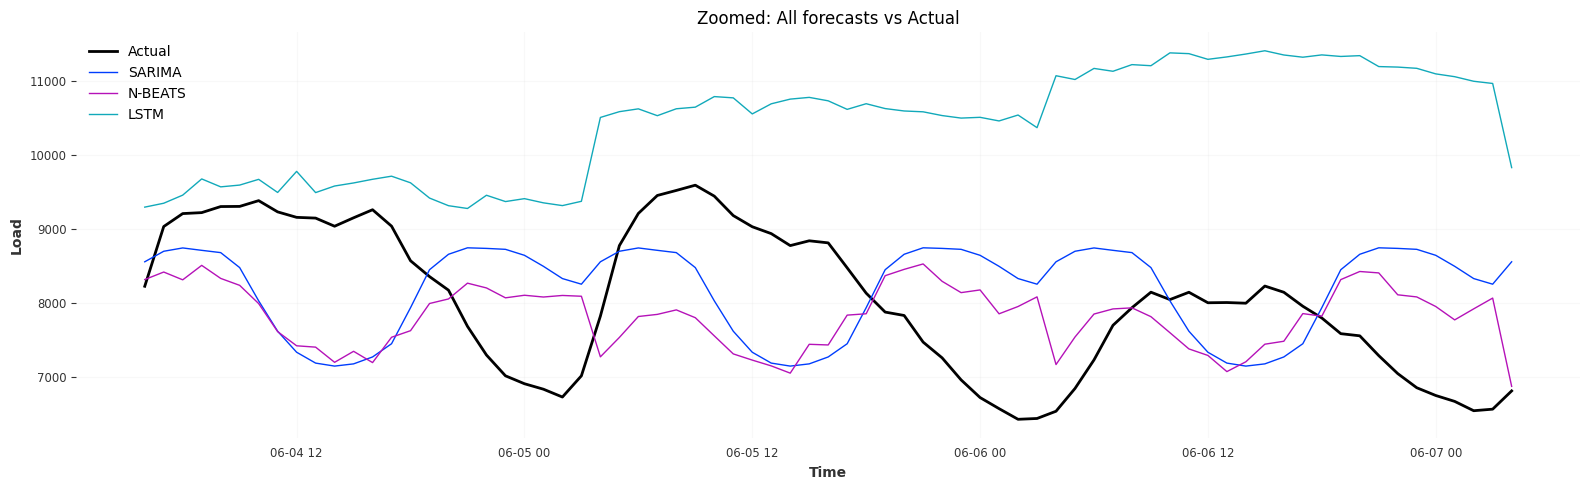

In [55]:
# Choose a window that contains interesting mistakes, e.g. first week:
window_start = actual_series.index[0]  # or actual_series.index[0] + pd.Timedelta(hours=168)
window_end = window_start + pd.Timedelta(days=3)  # 3-day zoom; adjust as needed

plt.figure(figsize=(16,5))
plt.plot(actual_series.loc[window_start:window_end], label='Actual', linewidth=2)
plt.plot(sarima_series.loc[window_start:window_end], label='SARIMA', linewidth=1)
plt.plot(nbeats_series.loc[window_start:window_end], label='N-BEATS', linewidth=1)
plt.plot(lstm_series.loc[window_start:window_end], label='LSTM', linewidth=1)
plt.title('Zoomed: All forecasts vs Actual')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

## The End